# **바로가기**
:: ***대구 교통 사고 피해 예측 AI 경진대회 Baseline Code***

- **[🔨 Fixed Random Seed](#section-1)**  
- **[💡 데이터 로드 및 확인하기](#section-2)**  
- **[💡 데이터 전처리](#section-3)**  
- **[📕 외부데이터 가져오기](#section-4)**  
- **[📊 EDA](#section-5)**  
- **[🚦 Preparing for Train](#section-6)**  
  - ✅ 해당 섹션에서 사용할 변수 지정해주기
  - 여기까지 실행 후 DL/ML 중 선택 학습  
- **[🚀 Model Train & Prediction (DL)](#section-7)**  
- **[🚀 Model Train & Prediction (ML)](#section-8)**  
- **[💾 Submission 파일 생성하기](#section-9)**
- **[⭐ Ensemble](#section-10)**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd ./drive/MyDrive/dacon/USER

/content/drive/MyDrive/dacon/USER


# **대구 교통 사고 피해 예측 AI 경진대회 Baseline Code**

## **🔨 Fixed Random Seed**  <a name="section-1"></a>

seed 값에 의해 동일한 코드를 사용해도 결과가 다를 수 있기에, 동일한 결과를 위해 seed 값 고정시키기

In [ ]:
!pip install koreanize-matplotlib
!pip install category_encoders

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import warnings
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

seed_number = 42   # TODO: seed 설정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)  # 시드설정추가

seed_everything(seed_number)
warnings.filterwarnings('ignore')

## **💡 데이터 로드 및 확인하기**  <a name="section-2"></a>

### **데이터 불러오기 및 상위행 확인**  

train.csv, test.csv 파일을 로드하여 상위행을 출력해 보자.

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)  # 모든 열 출력

train_org = pd.read_csv('data/train.csv')
test_org = pd.read_csv('data/test.csv')

display(train_org.head())
display(test_org.tail())

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차
10962,ACCIDENT_50571,2022-12-31 21,토요일,맑음,대구광역시 동구 효목동,교차로 - 교차로부근,건조,차대차


In [ ]:
display(train_org.shape)
display(test_org.shape)

(39609, 23)

(10963, 8)

### **train, test 데이터 기간 확인하기**  

학습(train) 데이터의 기간과 예측 대상이 되는 test 데이터의 기간을 살펴 보자.

In [ ]:
display(f"train : {train_org.iloc[0]['사고일시']} ~ {train_org.iloc[-1]['사고일시']}")
display(f"test : {test_org.iloc[0]['사고일시']} ~ {test_org.iloc[-1]['사고일시']}")

'train : 2019-01-01 00 ~ 2021-12-31 23'

'test : 2022-01-01 01 ~ 2022-12-31 21'

### **train 데이터 결측치 확인하기**  

In [ ]:
train_org.isnull().sum()

ID               0
사고일시             0
요일               0
기상상태             0
시군구              0
도로형태             0
노면상태             0
사고유형             0
사고유형 - 세부분류      0
법규위반             0
가해운전자 차종         0
가해운전자 성별         0
가해운전자 연령         0
가해운전자 상해정도       0
피해운전자 차종       991
피해운전자 성별       991
피해운전자 연령       991
피해운전자 상해정도     991
사망자수             0
중상자수             0
경상자수             0
부상자수             0
ECLO             0
dtype: int64

### **예측 대상 확인하기**

sample_submission.csv를 로드하여 출력 형식을 확인해 봄으로서,
대회 페이지 규칙에 기술되어 있는, 예측 대상이 무엇인지 확인해 보자.

최종적으로 예측해야 하는 값은 'ECLO'(인명피해 심각도) 값이다.

그러나, train데이터 컬럼에 있는 '사망자수', '중상자수', '경상자수', '부상자수'를 각각 예측하여 ECLO 예측값을 구할 수도 있다. 즉, ECLO 값을 예측하는 단일 모델로 접근할 수도,  각각을 별도로 예측하는 모델로 접근할 수도 있다.

<img src="https://drive.google.com/uc?id=19PvSqu8k04D3a-Bskcl-d-Xkckkn2Fvv">  

In [ ]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head()

,ID,ECLO
0,ACCIDENT_39609,0
1,ACCIDENT_39610,0
2,ACCIDENT_39611,0
3,ACCIDENT_39612,0
4,ACCIDENT_39613,0


## **💡 데이터 전처리**  <a name="section-3"></a>

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있다.  
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능하다.

### **파생 변수 생성 1 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [ ]:
train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

### **파생 변수 생성 2 : 공간(위치) 정보 생성**

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환한다.

In [ ]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

### **파생 변수 추출 3 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있다.  
이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성한다.

In [ ]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

### **파생 변수 추가 4 : 계절, 공휴일**  
'월' 컬럼을 통해 계절(봄, 여름, 가을, 겨울) 컬럼을 생성한다.  
'연', '월', '일'의 날짜를 통해 공휴일 여부를 표기하는 컬럼을 생성한다.

In [ ]:
def group_season(df):
    df.loc[(df['월'] == 3) | (df['월'] == 4) | (df['월'] == 5), '계절'] = '봄'
    df.loc[(df['월'] == 6) | (df['월'] == 7) | (df['월'] == 8), '계절'] = '여름'
    df.loc[(df['월'] == 9) | (df['월'] == 10) | (df['월'] == 11), '계절'] = '가을'
    df.loc[(df['월'] == 12) | (df['월'] == 1) | (df['월'] == 2), '계절'] = '겨울'
    return df['계절']
train_df['계절'] = group_season(train_df)
test_df['계절'] = group_season(test_df)

In [ ]:
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']

train_df['날짜'] = pd.to_datetime(train_df[['연', '월', '일']].astype(str).agg('-'.join, axis=1))
train_df['공휴일'] = train_df['날짜'].isin(pd.to_datetime(holi_weekday)).astype(int)
train_df = train_df.drop(columns=['날짜'])

test_df['날짜'] = pd.to_datetime(test_df[['연', '월', '일']].astype(str).agg('-'.join, axis=1))
test_df['공휴일'] = test_df['날짜'].isin(pd.to_datetime(holi_weekday)).astype(int)
test_df = test_df.drop(columns=['날짜'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '계절', '공휴일'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2', '계절', '공휴일'],\n      dtype='object')"

### **파생 변수 추가 6 : 총 사고발생횟수**  
'도시', '구', '동' 별로 총 사고발생횟수 세어 컬럼을 생성한다.

In [ ]:
train_total_df = train_df[['도시', '구', '동']].value_counts().reset_index(name='사고발생횟수')
test_tota_df = test_df[['도시', '구', '동']].value_counts().reset_index(name='사고발생횟수')

train_df = pd.merge(train_df, train_total_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, test_tota_df, how='left', on=['도시', '구', '동'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '계절', '공휴일',\n       '사고발생횟수'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수'],\n      dtype='object')"

### **파생 변수 추가 5 : '구' One-Hot-Encoding**  
총 8개 '구'를 One-Hot-Encoding 으로 8개의 컬럼을 추가 생성한다.

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# train_df와 test_df의 기상상태 및 노면상태 열 선택
train_categorical_data = train_df[['구']]
test_categorical_data = test_df[['구']]

# OneHotEncoder 인스턴스 생성 및 fit_transform 수행
encoder = OneHotEncoder()
train_encoded = encoder.fit_transform(train_categorical_data)
test_encoded = encoder.transform(test_categorical_data)

# OneHotEncoder가 사용한 카테고리 목록을 가져와서 카테고리 이름을 열 이름으로 변환
feature_names = encoder.get_feature_names_out(['구'])

# 밀집 행렬로 변환 (선택 사항)
train_encoded_dense = train_encoded.toarray()
test_encoded_dense = test_encoded.toarray()

train_encoded_df = pd.DataFrame(train_encoded_dense, columns=feature_names, index=train_df.index)
test_encoded_df = pd.DataFrame(test_encoded_dense, columns=feature_names, index=test_df.index)

# # 기존 열 제거
# train_df = train_df.drop(['구'], axis=1)
# test_df = test_df.drop(['구'], axis=1)

# 인코딩된 열 추가
train_df = pd.concat([train_df, train_encoded_df], axis=1)
test_df = pd.concat([test_df, test_encoded_df], axis=1)

### **전처리 결과 확인**

지금까지 전처리한 결과를 확인해보자.

In [ ]:
display(train_df.head())
display(test_df.head())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,길가장자리구역통행중,안전운전불이행,승용,여,51세,상해없음,보행자,여,70세,중상,0,1,0,0,5,2019,1,1,0,대구광역시,중구,대신동,단일로,기타,겨울,1,131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,보도통행중,기타,승용,남,39세,상해없음,보행자,남,61세,경상,0,0,1,0,3,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타,겨울,1,678,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,차도통행중,안전운전불이행,승용,남,70세,상해없음,보행자,남,38세,경상,0,0,1,0,3,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타,겨울,1,604,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,ACCIDENT_00003,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,49세,상해없음,승용,남,36세,중상,0,1,0,0,5,2019,1,1,2,대구광역시,북구,복현동,단일로,기타,겨울,1,426,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,ACCIDENT_00004,화요일,맑음,건조,차대차,추돌,안전운전불이행,승용,남,30세,상해없음,승용,남,52세,경상,0,0,1,0,3,2019,1,1,4,대구광역시,동구,신암동,단일로,기타,겨울,1,825,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안,겨울,1,102,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타,겨울,1,152,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안,겨울,1,39,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타,겨울,1,103,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안,겨울,1,149,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## **📕 외부데이터 가져오기** <a name="section-4"></a>


### **대구 보안등 정보.csv → 보안등개수**
- 대구에 존재하는 보안등 관련 정보
- '소재지지번주소' -> ['도시', '구', '동', '번지'] 분리
- 보안등 '설치연도' 가장 최신이 2019년이라 ['도시', '구', '동']에 대한 보안등개수 합 이용
  - `max(light_df['설치연도'].unique())  # 2019`
- train과 merge 시, train에 없는 데이터가 9513개 존재(NaN)
- test와 merge 시, test에는 없는 데이터가 2771개 존재(NaN)
  - train, test 둘다 0으로 변경

In [ ]:
light_df = pd.read_csv('data/external_open/대구 보안등 정보.csv', encoding='cp949')

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.groupby(['도시', '구', '동'])['설치개수'].sum().reset_index()
light_df.rename(columns={'설치개수': '보안등개수'}, inplace=True)

light_df.head()

,도시,구,동,보안등개수
0,대구광역시,남구,대명동,5377
1,대구광역시,남구,봉덕동,1424
2,대구광역시,남구,이천동,556
3,대구광역시,달서구,갈산동,349
4,대구광역시,달서구,감삼동,932


In [ ]:
train_df = pd.merge(train_df, light_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, light_df, how='left', on=['도시', '구', '동'])

train_df['보안등개수'].fillna(0, inplace=True)   # nan을 0으로 변경
test_df['보안등개수'].fillna(0, inplace=True)

train_df['보안등개수'] = train_df['보안등개수'].astype(int) # 데이터타입 정수형으로 변경
test_df['보안등개수'] = test_df['보안등개수'].astype(int)

display(train_df.sample())
display(test_df.sample())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수
8707,ACCIDENT_08707,금요일,맑음,건조,차대사람,횡단중,보행자보호의무위반,승용,여,35세,상해없음,보행자,여,77세,중상,0,1,0,0,5,2019,8,16,9,대구광역시,동구,효목동,단일로,기타,여름,0,597,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1164


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수
3156,ACCIDENT_42765,월요일,맑음,건조,차대차,2022,4,25,18,대구광역시,수성구,대흥동,단일로,기타,봄,0,23,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


### **대구 어린이 보호 구역 정보.csv → 어린이보호구역개수**
- 대구에 존재하는 어린이 보호 구역 관련 정보
- '소재지지번주소' -> ['도시', '구', '동', '번지'] 분리
- train과 merge 시, train에 없는 데이터가 18426개 존재(NaN)
- test와 merge 시, test에는 없는 데이터가 4961개 존재(NaN)
  - train, test 둘다 0으로 변경

In [ ]:
child_area_df = pd.read_csv('data/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949')

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

# child_area_df['어린이보호구역개수'] = 1
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df[['도시', '구', '동']].value_counts().reset_index(name='어린이보호구역개수')

child_area_df.head()

,도시,구,동,어린이보호구역개수
0,대구광역시,달성군,다사읍,60
1,대구광역시,달성군,화원읍,38
2,대구광역시,남구,대명동,26
3,대구광역시,달성군,논공읍,22
4,대구광역시,달성군,옥포면,22


In [ ]:
train_df = pd.merge(train_df, child_area_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['도시', '구', '동'])

train_df['어린이보호구역개수'].fillna(0, inplace=True)   # nan을 0으로 변경
test_df['어린이보호구역개수'].fillna(0, inplace=True)

train_df['어린이보호구역개수'] = train_df['어린이보호구역개수'].astype(int) # 데이터타입 정수형으로 변경
test_df['어린이보호구역개수'] = test_df['어린이보호구역개수'].astype(int)

display(train_df.sample())
display(test_df.sample())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수
11001,ACCIDENT_11001,목요일,맑음,건조,차대사람,횡단중,안전운전불이행,승용,남,26세,상해없음,보행자,남,18세,중상,0,1,0,0,5,2019,10,10,22,대구광역시,달서구,도원동,단일로,기타,가을,0,232,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,91,0


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수
5203,ACCIDENT_44812,화요일,맑음,건조,차대차,2022,6,28,12,대구광역시,동구,대림동,단일로,기타,여름,0,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,0


### **대구 주차장 정보.csv → (급지분류_1, 2, 3), 주차장개수**
- 대구에 존재하는 주차장 관련 정보   

**1. 주차장을 급지구분으로 One-Hot-Encoding**
  - train과 merge 시, train에 없는 데이터가 6543개 존재(NaN)
  - test와 merge 시, test에는 없는 데이터가 1928개 존재(NaN)

In [ ]:
parking_df = pd.read_csv('data/external_open/대구 주차장 정보.csv', encoding='cp949')
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.groupby(['도시', '구', '동'])[['급지구분_1', '급지구분_2', '급지구분_3']].sum().reset_index()

parking_df.head()

,도시,구,동,급지구분_1,급지구분_2,급지구분_3
0,대구광역시,남구,대명동,20,1,0
1,대구광역시,남구,봉덕동,9,3,0
2,대구광역시,남구,이천동,3,0,0
3,대구광역시,달서구,갈산동,0,0,4
4,대구광역시,달서구,감삼동,0,1,3


In [ ]:
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

train_df['급지구분_1'].fillna(0, inplace=True)   # nan을 0으로 변경
test_df['급지구분_1'].fillna(0, inplace=True)
train_df['급지구분_2'].fillna(0, inplace=True)
test_df['급지구분_2'].fillna(0, inplace=True)
train_df['급지구분_3'].fillna(0, inplace=True)
test_df['급지구분_3'].fillna(0, inplace=True)

train_df['급지구분_1'] = train_df['급지구분_1'].astype(int) # 데이터타입 정수형으로 변경
test_df['급지구분_1'] = test_df['급지구분_1'].astype(int)
train_df['급지구분_2'] = train_df['급지구분_2'].astype(int)
test_df['급지구분_2'] = test_df['급지구분_2'].astype(int)
train_df['급지구분_3'] = train_df['급지구분_3'].astype(int)
test_df['급지구분_3'] = test_df['급지구분_3'].astype(int)

display(train_df.sample())
display(test_df.sample())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수,급지구분_1,급지구분_2,급지구분_3
12298,ACCIDENT_12298,토요일,맑음,건조,차대차,추돌,안전운전불이행,화물,남,50세,상해없음,승용,남,46세,경상,0,0,2,0,6,2019,11,9,19,대구광역시,동구,동호동,단일로,기타,가을,0,188,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,205,0,0,0,1


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수,급지구분_1,급지구분_2,급지구분_3
1524,ACCIDENT_41133,토요일,맑음,건조,차대차,2022,2,26,20,대구광역시,달서구,유천동,기타,기타,겨울,0,72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65,0,0,0,0


**2. 주차장 개수로 나눔**
  - train과 merge 시, train에 없는 데이터가 6543개 존재(NaN)
  - test와 merge 시, test에는 없는 데이터가 1928개 존재(NaN)

In [ ]:
parking_df = pd.read_csv('data/external_open/대구 주차장 정보.csv', encoding='cp949')

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df[['도시', '구', '동']].value_counts().reset_index(name='주차장개수')

parking_df.head()

,도시,구,동,주차장개수
0,대구광역시,서구,비산동,49
1,대구광역시,북구,산격동,42
2,대구광역시,북구,노원동3가,29
3,대구광역시,달성군,논공읍,29
4,대구광역시,북구,침산동,25


In [ ]:
train_df = pd.merge(train_df, parking_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, parking_df, how='left', on=['도시', '구', '동'])

train_df['주차장개수'].fillna(0, inplace=True)   # nan을 0으로 변경
test_df['주차장개수'].fillna(0, inplace=True)

train_df['주차장개수'] = train_df['주차장개수'].astype(int) # 데이터타입 정수형으로 변경
test_df['주차장개수'] = test_df['주차장개수'].astype(int)

display(train_df.sample())
display(test_df.sample())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수,급지구분_1,급지구분_2,급지구분_3,주차장개수
35879,ACCIDENT_35879,일요일,맑음,건조,차대차,정면충돌,교차로운행방법위반,승용,남,70세,상해없음,승용,여,49세,경상,0,0,1,0,3,2021,9,12,18,대구광역시,달서구,유천동,교차로,교차로안,가을,0,193,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,65,0,0,0,0,0


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수,급지구분_1,급지구분_2,급지구분_3,주차장개수
233,ACCIDENT_39842,월요일,맑음,건조,차대차,2022,1,10,6,대구광역시,수성구,만촌동,교차로,교차로횡단보도내,겨울,0,277,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,18,0,0,3,3


### **대구 CCTV 정보.csv → CCTV개수**
- 대구에 존재하는 CCTV 관련 정보
  - 도로노선방향
    - 01 : 상행
    - 02 : 하행
    - 03 : 양방향
  - 단속구분
    - 01 : 속도
    - 02 : 신호
    - 03 : 통행위반
    - 04 : 불법주정차
    - 99 : 기타
  - 단속구간위치구분
    - 01 : 시점
    - 02 : 종점
  - 보호구역구분
    - 01 : 노인보호구역
    - 02 : 어린이보호구역
    - 99 : 기타

In [ ]:
cctv_df = pd.read_csv('data/external_open/대구 CCTV 정보.csv', encoding='cp949')

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

cctv_df[['도시', '구', '동', '번지']] = cctv_df['소재지지번주소'].str.extract(location_pattern)
cctv_df = cctv_df[['도시', '구', '동']].value_counts().reset_index(name='CCTV개수')

cctv_df.head()

,도시,구,동,CCTV개수
0,대구광역시,남구,대명동,62
1,대구광역시,달성군,다사읍,44
2,대구광역시,달서구,용산동,33
3,대구광역시,달성군,화원읍,33
4,대구광역시,달서구,상인동,30


In [ ]:
train_df = pd.merge(train_df, cctv_df, how='left', on=['도시', '구', '동'])
test_df = pd.merge(test_df, cctv_df, how='left', on=['도시', '구', '동'])

train_df['CCTV개수'].fillna(0, inplace=True)   # nan을 0으로 변경
test_df['CCTV개수'].fillna(0, inplace=True)

train_df['CCTV개수'] = train_df['CCTV개수'].astype(int)   # 데이터타입 정수형으로 변경
test_df['CCTV개수'] = test_df['CCTV개수'].astype(int)

display(train_df.sample())
display(test_df.sample())

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수,급지구분_1,급지구분_2,급지구분_3,주차장개수,CCTV개수
29411,ACCIDENT_29411,목요일,비,젖음/습기,차대차,측면충돌,안전운전불이행,이륜,남,34세,경상,승용,남,26세,상해없음,0,0,1,0,3,2021,3,4,20,대구광역시,달서구,송현동,단일로,기타,봄,0,811,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1365,0,0,7,7,14,17


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수,급지구분_1,급지구분_2,급지구분_3,주차장개수,CCTV개수
8716,ACCIDENT_48325,금요일,맑음,건조,차량단독,2022,10,21,2,대구광역시,수성구,두산동,단일로,기타,가을,0,166,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,473,5,0,0,0,0,4


## **📊 EDA** <a name="section-5"></a>

### ***train 데이터의 ECLO 분포 살펴보기***
---
**Insight**
- 1부터 74까지 ECLO가 분포되어있다.
- ECLO가 6 이하인 데이터가 현저히 많다.
- ECLO가 40 이상인 데이터를 살펴봐도 날씨나 요일 등 특이한점은 못발견하였다.
다만, 대부분 오후 시간대이고, 사고유형, 노면상태, 도로형태가 비슷해보였던 것 같다.

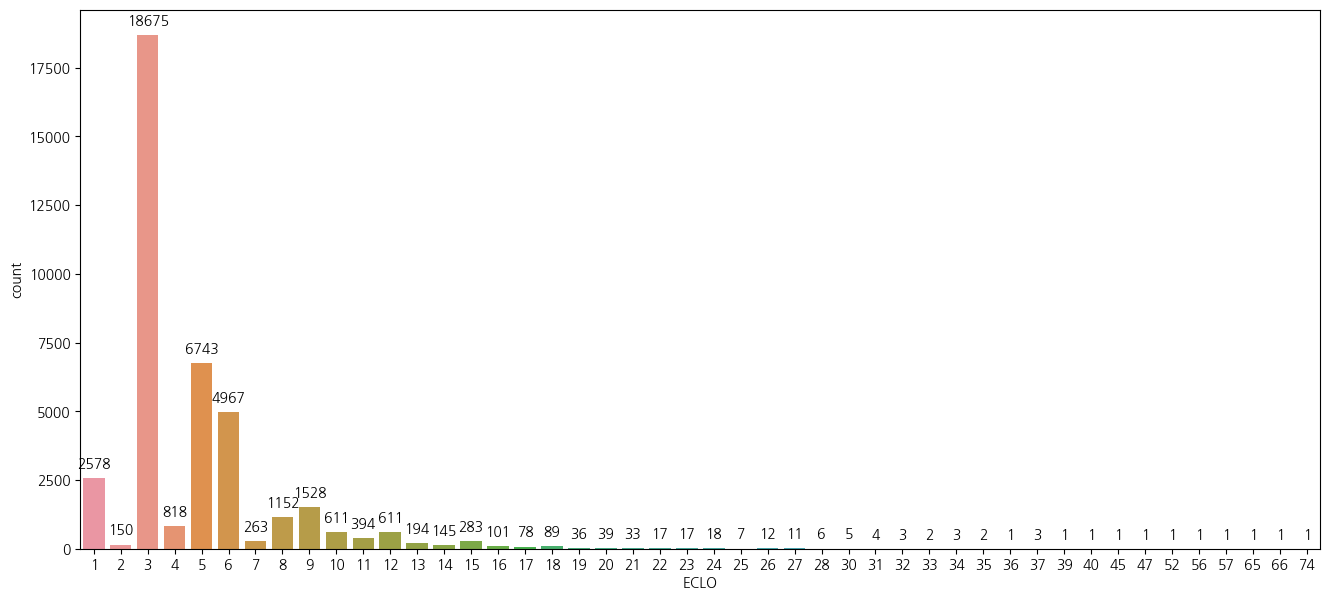

In [ ]:
plt.figure(figsize=(16, 7))
ax = sns.countplot(x='ECLO', data=train_df)
for p in ax.patches:
  ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [ ]:
train_df[train_df['ECLO'] >= 40].sort_values('ECLO')

,ID,요일,기상상태,노면상태,사고유형,사고유형 - 세부분류,법규위반,가해운전자 차종,가해운전자 성별,가해운전자 연령,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO,연,월,일,시간,도시,구,동,도로형태1,도로형태2,계절,공휴일,사고발생횟수,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,보안등개수,어린이보호구역개수,급지구분_1,급지구분_2,급지구분_3,주차장개수,CCTV개수
354,ACCIDENT_00354,토요일,비,젖음/습기,차대차,측면충돌,신호위반,승용,남,20세,중상,승합,남,38세,중상,2,4,0,0,40,2019,1,12,5,대구광역시,달성군,유가읍,교차로,교차로안,겨울,0,247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,454,12,0,0,2,2,13
29350,ACCIDENT_29350,화요일,맑음,건조,차대차,추돌,안전거리미확보,승용,남,38세,상해없음,승합,남,46세,경상,0,0,15,0,45,2021,3,2,18,대구광역시,북구,침산동,교차로,교차로부근,봄,0,668,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,732,7,8,15,2,25,16
5358,ACCIDENT_05358,목요일,맑음,건조,차대차,기타,차로위반,승용,남,27세,기타불명,승합,남,44세,상해없음,0,1,14,0,47,2019,5,23,19,대구광역시,달서구,송현동,교차로,교차로부근,봄,0,811,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1365,0,0,7,7,14,17
30002,ACCIDENT_30002,월요일,맑음,건조,차대차,추돌,안전운전불이행,화물,남,57세,부상신고,승용,남,37세,사망,1,4,7,1,52,2021,3,22,15,대구광역시,서구,상리동,단일로,기타,봄,0,153,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,0,4,4,1
10834,ACCIDENT_10834,월요일,비,젖음/습기,차대차,기타,안전운전불이행,화물,남,62세,경상,승합,남,53세,중상,0,4,12,0,56,2019,10,7,17,대구광역시,달성군,논공읍,교차로,교차로부근,가을,0,258,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1153,22,0,0,29,29,18
12632,ACCIDENT_12632,일요일,맑음,건조,차대차,정면충돌,안전운전불이행,승용,여,52세,상해없음,승용,남,73세,사망,1,4,9,0,57,2019,11,17,11,대구광역시,수성구,만촌동,단일로,기타,가을,0,908,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,18,0,0,3,3,15
10155,ACCIDENT_10155,일요일,맑음,젖음/습기,차량단독,공작물충돌,과속,승합,남,45세,상해없음,NaN,NaN,NaN,NaN,1,2,15,0,65,2019,9,22,15,대구광역시,동구,신평동,단일로,기타,가을,0,34,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,237,0,0,0,0,0,5
37536,ACCIDENT_37536,월요일,맑음,건조,차대차,추돌,안전운전불이행,화물,남,54세,상해없음,승용,남,22세,경상,0,0,22,0,66,2021,11,1,9,대구광역시,북구,노곡동,단일로,기타,가을,0,18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,140,0,0,0,3,3,0
32591,ACCIDENT_32591,금요일,맑음,건조,차대차,추돌,안전운전불이행,승합,여,61세,상해없음,승합,남,48세,상해없음,0,4,18,0,74,2021,6,4,14,대구광역시,서구,비산동,단일로,기타,여름,0,968,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,19,6,30,13,49,14


### ***각 column별 Train 데이터 ECLO 평균 / Train과 Test 데이터 갯수***

---
**Insight**

→ 모든 컬럼에서 train과 test 데이터셋 분포가 비슷하다.

**🟣 요일**
- 토요일/일요일(주말)에 ECLO가 보다 높다.
- train, test 둘다 일요일 데이터가 적다.

**🟣 기상상태**
- 안개 낀 날 ECLO가 높음. 그러나 train에는 8개 데이터밖에 없다.  
또한, test에는 안개 데이터가 없다.

**🟣 노면상태**
- 침수된 날 ECLO가 높다, 적설인 경우 ECLO 낮다.

**🟣 사고유형**
- 차대차 ECLO가 높고, 데이터도 가장 많다.

**🟣 연**
- 연도가 지날수록 ECLO가 낮아지고, 데이터갯수도 줄어든 것을 볼 수 있다.
  - 연도가 흐를수록 사고에 더 잘 대비하는 걸까?
- 하지만, 이미 사고가 난 데이터에 대해 ECLO를 예측하는 것(즉, ECLO가 0인 경우 X)이기에 연도가 과연 의미가 있는지 모르겠다.

**🟣 월**
- 월별 ECLO는 비슷한 것 같다.
- 2, 3월 날 데이터는 적은데 ECLO는 높은 편, 크게 사고 난 걸까?

**🟣 일**
- 일별 ECLO는 비슷한 것 같다.
- 31일 날 데이터가 적은 건 당연한 듯 보인다.

**🟣 시간**
- 새벽 시간대 ECLO가 높은데 데이터는 적다 (적지만 크게 사고가 나는 것 같다)
  - 어두워서 차대사람 사고가 많이 나는 걸까? (이후 가설검정 결과 아니었다.)
- 8시 출근시간대에 주변시간대보다 비교적 사고가 많이 발생한 듯 보인다.
- 오후 시간대로 갈수록 사고가 더 발생하고, 18시 퇴근시간대에 사고가 가장 많이 났다.
- 늦은 저녁시간대(새벽)에 갈수록 점점 사고가 줄어든다.

**🟣 구**
- 달성군에 사고는 적지만 큰 사고 위주로 발생한 것 같다.
- 달서구, 수성구, 북구, 동구에서 사고가 많이 발생하였다.

**🟣 동**
- 노곡동, 덕곡동, 대안동에서 ECLO가 유독 높다.
- 동일동, 종로2가에서 ECLO가 낮다.

**🟣 도로형태1**
- 교차로, 단일로에서 ECLO가 높고, 데이터도 많다.

**🟣 도로형태2**
- 터널에서 ECLO가 높고, 데이터는 적다.

**🟣 계절**
- 계절별 ECLO 평균은 비슷하다.
- 겨울 데이터가 다른 계절보다 적은 편이다.

**🟣 공휴일**
- 공휴일 날에 공휴일이 아닌 날보다 ECLO가 높은 편이다.

**🟣 사고발생횟수**
- 사고발생횟수별 ECLO는 비슷한 편이다.
- 사고발생횟수가 높은 데이터가 많다.

**🟣 보안등개수**
- 보안등개수별 ECLO는 일부를 제외하고 비슷한 편이다.
- 보안등 개수가 0일 때, 가장 데이터가 많다.

**🟣 어린이보호구역개수**
- 어린이보호구역개수별 ECLO는 비슷하다.
- 어린이보호구역이 0일 때, 가장 데이터가 많다.

**🟣 주차장개수**
- 주차장개수별 ECLO는 비슷하다.
- 주차장 개수가 4개 이하인 데이터가 많다.

**🟣 CCTV개수**
- CCTV개수별 ECLO는 비슷하다.
- CCTV가 12개일 때 가장 데이터가 많다.


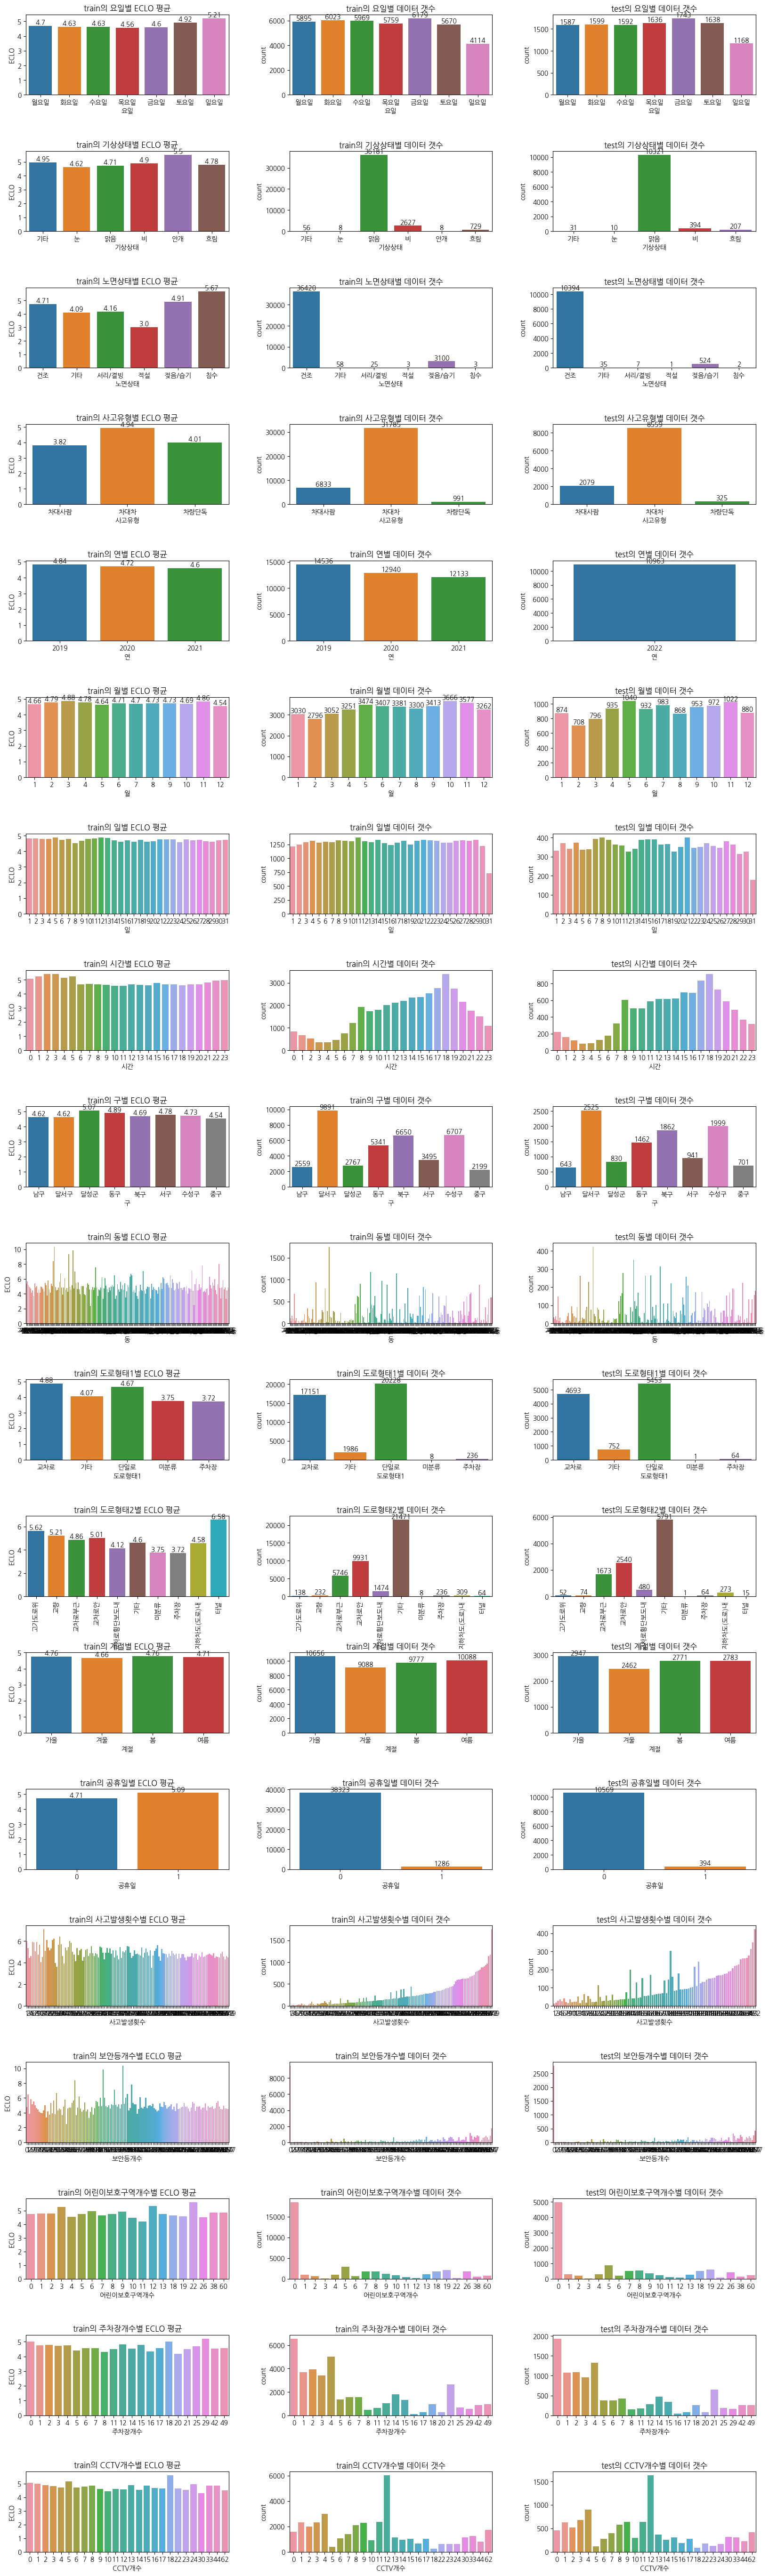

In [ ]:
check_columns = ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2',
                 '계절', '공휴일', '사고발생횟수', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

temp_train_df = train_df.copy()
temp_train_df = temp_train_df.drop(['ID'], axis=1)
temp_test_df = test_df.drop(['ID'], axis=1).copy()

# 요일 월~일 순으로 고정시키기
weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

plt.figure(figsize=(20, 70))
for i, col in enumerate(check_columns):
  if col in ['요일']:
    temp_train_df = temp_train_df.sort_values(by='요일', key=lambda x: x.astype(pd.CategoricalDtype(categories=weekday_order, ordered=True)))
  else:
    temp_train_df = temp_train_df.sort_values(col)

  plt.subplot(len(check_columns), 3, i*3+1)
  plt.title(f'train의 {col}별 ECLO 평균')
  ax1 = sns.barplot(data=temp_train_df, x=col, y='ECLO', errorbar=None)
  if col in ['도로형태2']:
    plt.xticks(rotation=90)
  if col in ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '구', '도로형태1', '도로형태2', '계절', '공휴일']:
    for p in ax1.patches:
        ax1.annotate(f'{round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')


  plt.subplot(len(check_columns), 3, i*3+2)
  plt.title(f'train의 {col}별 데이터 갯수')
  ax2 = sns.countplot(data=temp_train_df, x=col)
  if col in ['도로형태2']:
    plt.xticks(rotation=90)
  if col in ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '구', '도로형태1', '도로형태2', '계절', '공휴일']:
    for p in ax2.patches:
        ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')


  if col in ['요일']:
    temp_test_df = temp_test_df.sort_values(by='요일', key=lambda x: x.astype(pd.CategoricalDtype(categories=weekday_order, ordered=True)))
  else:
    temp_test_df = temp_test_df.sort_values(col)
  plt.subplot(len(check_columns), 3, i*3+3)
  plt.title(f'test의 {col}별 데이터 갯수')
  ax3 = sns.countplot(data=temp_test_df, x=col)
  if col in ['도로형태2']:
    plt.xticks(rotation=90)
  if col in ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '구', '도로형태1', '도로형태2', '계절', '공휴일']:
    for p in ax3.patches:
        ax3.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.subplots_adjust(hspace=0.7, wspace=0.3)

#### **'동' 컬럼의 ECLO 살펴보기**

In [ ]:
temp_train_df.groupby(['동'])['ECLO'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
동,,,,,,,,
노곡동,18.0,10.333333,15.442493,3.0,3.00,5.0,8.75,66.0
덕곡동,8.0,9.875000,5.890367,3.0,5.50,9.0,13.00,20.0
대안동,3.0,9.333333,3.511885,6.0,7.50,9.0,11.00,13.0
내동,5.0,8.400000,5.272571,3.0,5.00,6.0,13.00,15.0
하서동,10.0,8.000000,10.964589,1.0,2.25,3.5,8.25,37.0
...,...,...,...,...,...,...,...,...
서성로2가,9.0,3.333333,1.581139,1.0,3.00,3.0,5.00,5.0
북성로1가,18.0,3.333333,2.249183,1.0,1.25,3.0,4.50,8.0
미대동,10.0,3.300000,1.337494,1.0,3.00,3.0,3.00,6.0


#### **새벽 시간대는 어두워서 '차대사람' 사고가 자주 나는 걸까?**
새벽 시간대에 데이터 수는 적은데 ECLO가 큰 이유가 어두워서 '차대사람' 사고가 많은 건지 가설을 세우고 분석해 보니 '사고유형'과는 큰 연관이 없어 보였다.
오히려 새벽 시간대에 새벽 외 시간대보다 '추돌'과 '신호위반'으로 인한 사고가 자주 발생한 듯 보였다 -> 새벽에 무단횡단하는 사람이 많은 비슷한 원리?

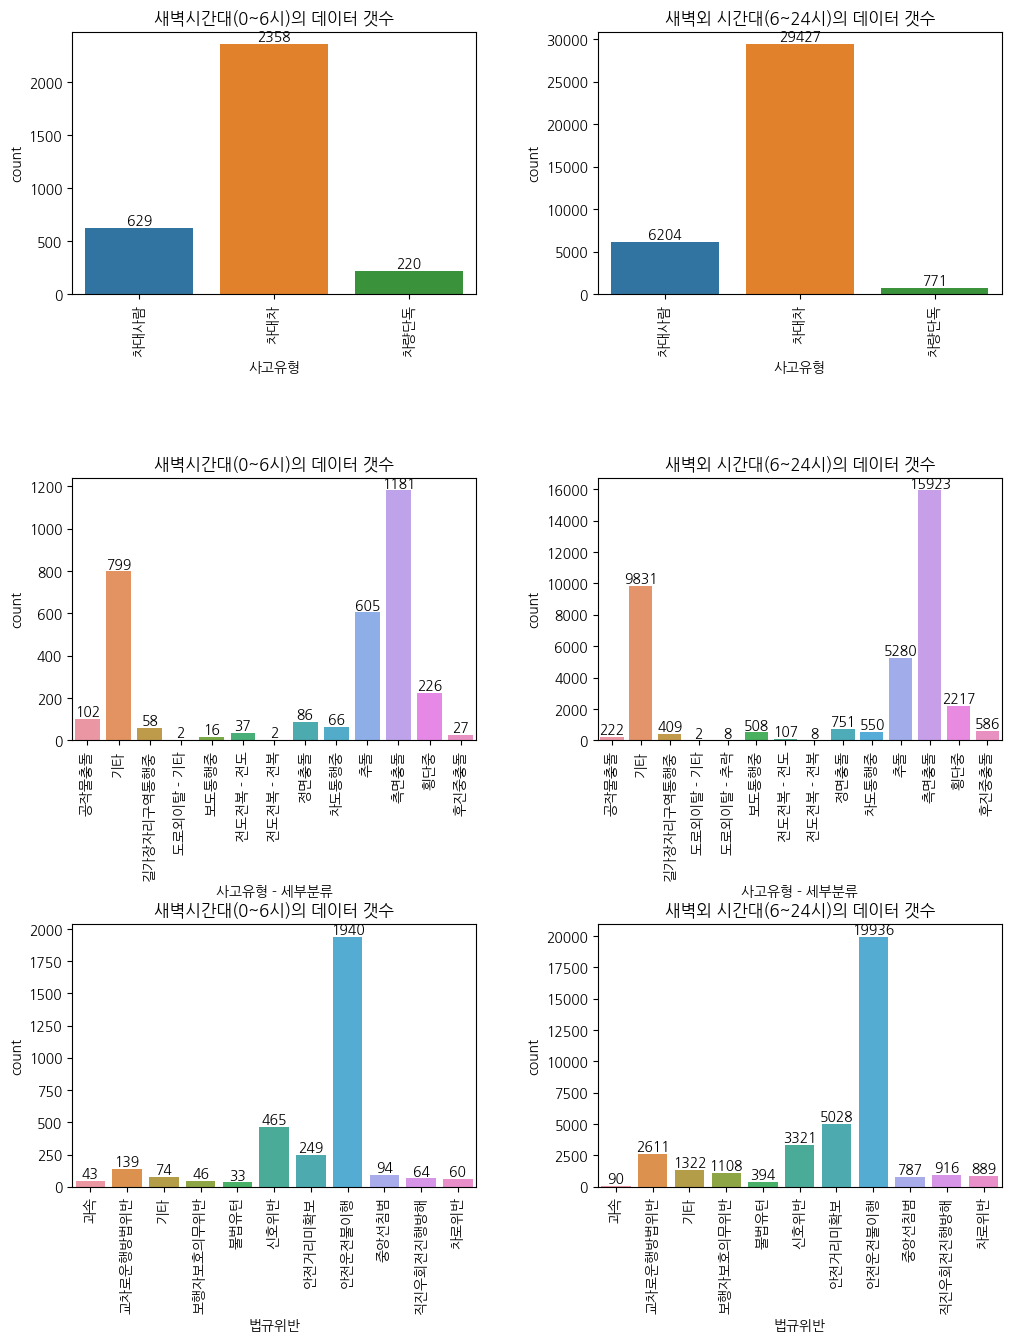

In [ ]:
time_dawn_df = temp_train_df[(temp_train_df['시간'] >= 0) & (temp_train_df['시간'] <= 5)]
time_dawn_not_df = temp_train_df[(temp_train_df['시간'] >= 6) & (temp_train_df['시간'] <= 23)]
time_check_columns = ['사고유형', '사고유형 - 세부분류', '법규위반']

plt.figure(figsize=(12, 15))
for i, col in enumerate(time_check_columns):
  time_dawn_df = time_dawn_df.sort_values(col)
  plt.subplot(len(time_check_columns), 2, 2*i+1)
  plt.title(f'새벽시간대(0~6시)의 데이터 갯수')
  plt.xticks(rotation=90)
  ax1 = sns.countplot(data=time_dawn_df, x=col)
  for p in ax1.patches:
          ax1.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

  time_dawn_not_df = time_dawn_not_df.sort_values(col)
  plt.subplot(len(time_check_columns), 2, 2*i+2)
  plt.title(f'새벽외 시간대(6~24시)의 데이터 갯수')
  plt.xticks(rotation=90)
  ax2 = sns.countplot(data=time_dawn_not_df, x=col)
  for p in ax2.patches:
          ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.subplots_adjust(hspace=0.7, wspace=0.3)

### ***각 column별 ECLO의 Boxplot 그려보기***
- 빨간점선 : ECLO 평균
- 각 column별의 세부요소들에 대한 boxplot 그려서 boxplot의 세부요소들(최대값, 분위수 등)이 어디 분포되어있는지 보기

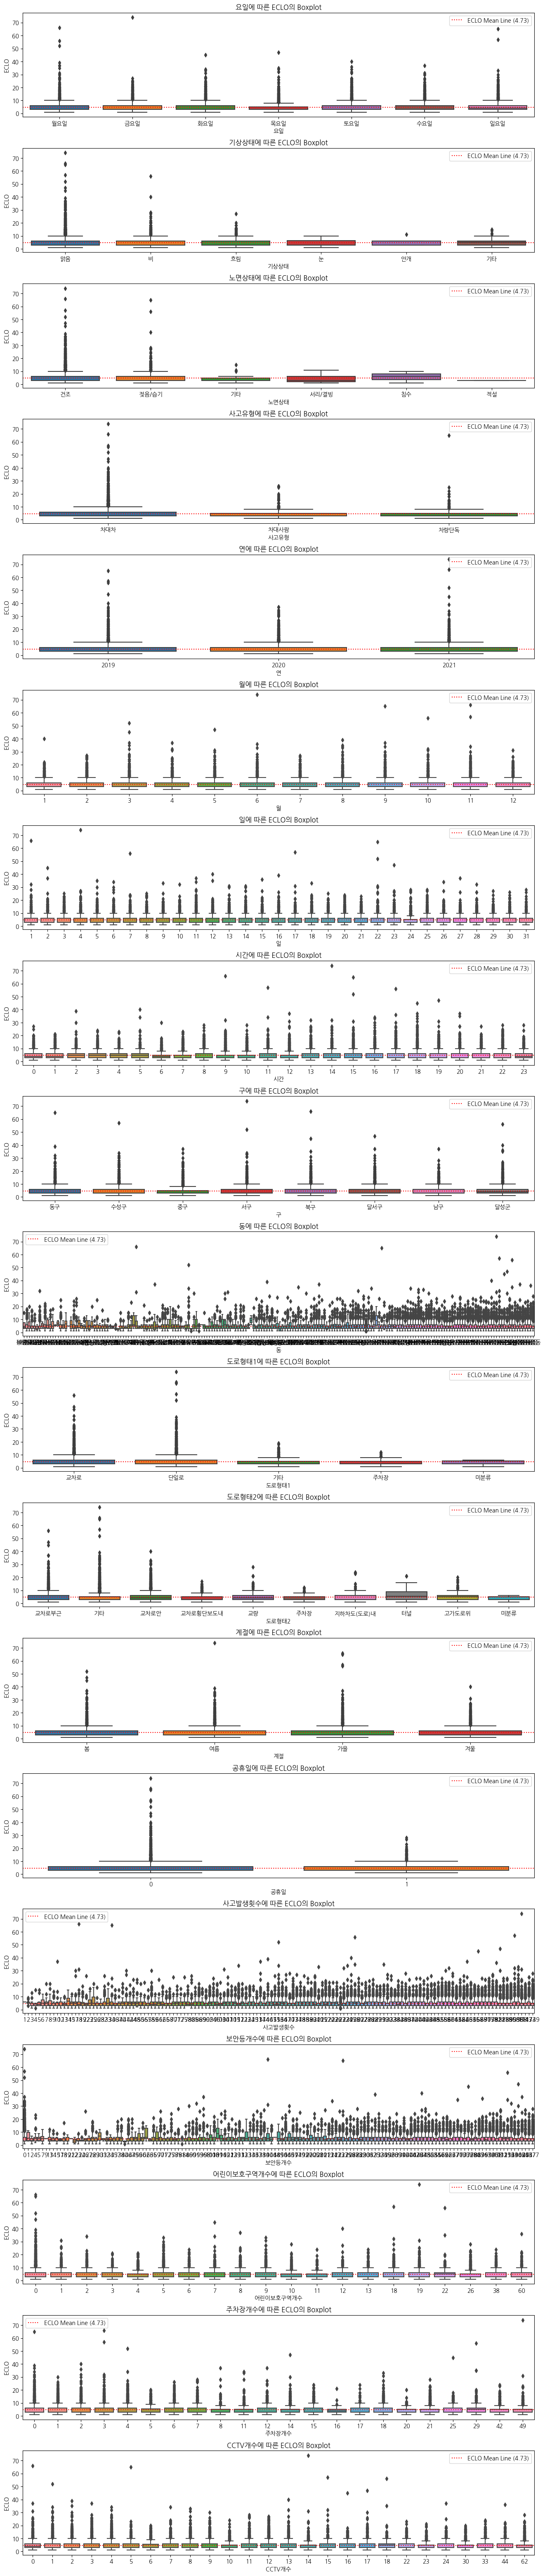

In [ ]:
plt.figure(figsize=(16, 80))
avg = round(temp_train_df['ECLO'].mean(), 2)
for i, col in enumerate(check_columns):
  plt.subplot(len(check_columns), 1, i+1)
  plt.axhline(avg, ls=':', label=f'ECLO Mean Line ({avg})', color='r')
  plt.legend()
  plt.title(f'{col}에 따른 ECLO의 Boxplot')
  sns.boxplot(data=temp_train_df, x=col, y='ECLO')
plt.subplots_adjust(hspace=0.3)

### ***'사망자/중상자/경상자/부상자수'에 따른 ECLO 평균 분포***
'사망자'는 최대 2명이고, 오히려 '경상자수'가 최대 22명까지 많다.

<Axes: xlabel='부상자수', ylabel='ECLO'>

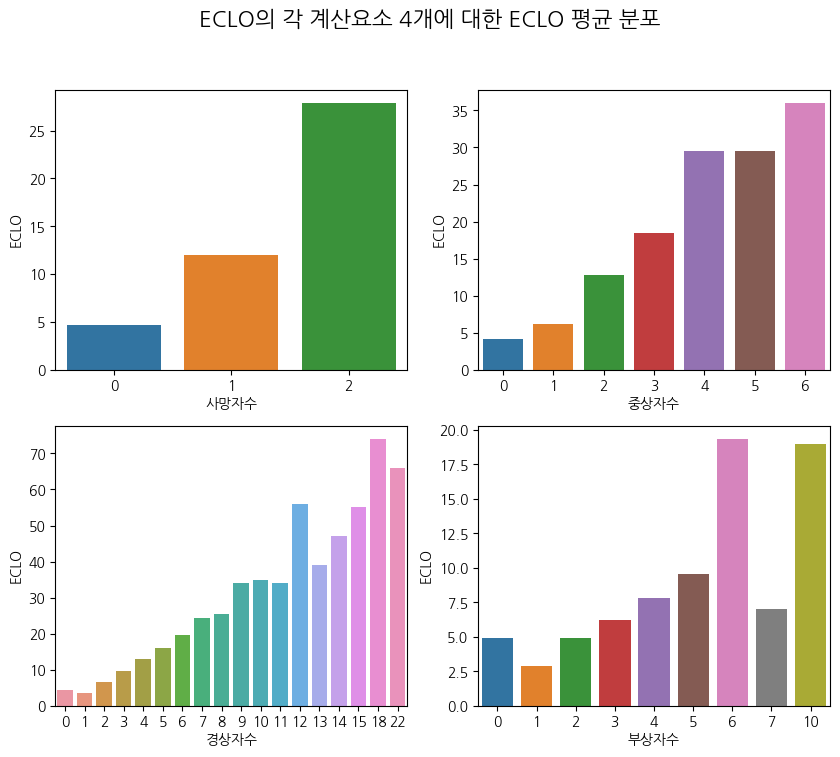

In [ ]:
plt.figure(figsize=(10, 8))
plt.suptitle('ECLO의 각 계산요소 4개에 대한 ECLO 평균 분포', fontsize=16)
plt.subplot(2, 2, 1)
sns.barplot(x='사망자수', y='ECLO', data=temp_train_df, errorbar=None)
plt.subplot(2, 2, 2)
sns.barplot(x='중상자수', y='ECLO', data=temp_train_df, errorbar=None)
plt.subplot(2, 2, 3)
sns.barplot(x='경상자수', y='ECLO', data=temp_train_df, errorbar=None)
plt.subplot(2, 2, 4)
sns.barplot(x='부상자수', y='ECLO', data=temp_train_df, errorbar=None)

In [ ]:
column_75th_percentile = train_df['사망자수'].quantile(0.75)
train_df[train_df['사망자수'] > column_75th_percentile]['사망자수']

95       1
127      1
164      1
187      1
354      2
        ..
38936    1
38997    1
39049    2
39197    1
39337    2
Name: 사망자수, Length: 300, dtype: int64

In [ ]:
display(temp_train_df.groupby(['사망자수'])['ECLO'].describe())
display(temp_train_df.groupby(['중상자수'])['ECLO'].describe())
display(temp_train_df.groupby(['경상자수'])['ECLO'].describe())
display(temp_train_df.groupby(['부상자수'])['ECLO'].describe())

,count,mean,std,min,25%,50%,75%,max
사망자수,,,,,,,,
0,39309.0,4.667786,3.099511,1.0,3.00,3.0,6.0,74.0
1,292.0,12.023973,5.715125,10.0,10.00,10.0,13.0,65.0
2,8.0,27.875000,6.621124,20.0,23.75,28.0,31.0,40.0


,count,mean,std,min,25%,50%,75%,max
중상자수,,,,,,,,
0,30136.0,4.089428,2.682082,1.0,3.00,3.0,6.00,66.0
1,8724.0,6.103851,2.656883,5.0,5.00,5.0,5.00,47.0
2,618.0,12.849515,4.616756,10.0,10.00,10.0,14.00,65.0
3,98.0,18.448980,4.581726,15.0,15.00,18.0,21.00,37.0
4,28.0,29.571429,13.742145,20.0,20.00,26.0,28.25,74.0
5,4.0,29.500000,3.872983,25.0,27.25,29.5,31.75,34.0
6,1.0,36.000000,NaN,36.0,36.00,36.0,36.00,36.0


,count,mean,std,min,25%,50%,75%,max
경상자수,,,,,,,,
0,10284.0,4.332069,2.510408,1.0,1.0,5.0,5.0,40.0
1,20913.0,3.441878,1.619412,3.0,3.0,3.0,3.0,33.0
2,5560.0,6.673381,2.223720,6.0,6.0,6.0,6.0,36.0
3,1728.0,9.704861,2.174426,9.0,9.0,9.0,9.0,34.0
4,732.0,12.930328,2.472128,12.0,12.0,12.0,12.0,32.0
5,259.0,15.988417,2.614039,15.0,15.0,15.0,15.0,30.0
6,77.0,19.727273,3.393633,18.0,18.0,18.0,19.0,33.0
7,32.0,24.281250,6.702115,21.0,21.0,21.0,26.0,52.0
8,7.0,25.428571,3.779645,24.0,24.0,24.0,24.0,34.0


,count,mean,std,min,25%,50%,75%,max
부상자수,,,,,,,,
0,35168.0,4.927491,3.093049,3.0,3.0,3.0,6.0,74.0
1,4046.0,2.891251,3.367192,1.0,1.0,1.0,4.0,52.0
2,279.0,4.921147,4.437522,2.0,2.0,2.0,7.0,30.0
3,67.0,6.223881,3.945926,3.0,3.0,6.0,9.0,20.0
4,35.0,7.771429,5.380169,4.0,4.0,7.0,10.0,24.0
5,9.0,9.555556,8.094923,5.0,5.0,5.0,10.0,30.0
6,3.0,19.333333,15.947832,6.0,10.5,15.0,26.0,37.0
7,1.0,7.000000,NaN,7.0,7.0,7.0,7.0,7.0
10,1.0,19.000000,NaN,19.0,19.0,19.0,19.0,19.0


### ***'가해/피해운전자'의 성별 분포***
확실히 남성 운전자가 여성 운전자에 비해 많아서 사고 성별도 남성이 높게 나오는 것 같다.

<Axes: xlabel='피해운전자 성별', ylabel='count'>

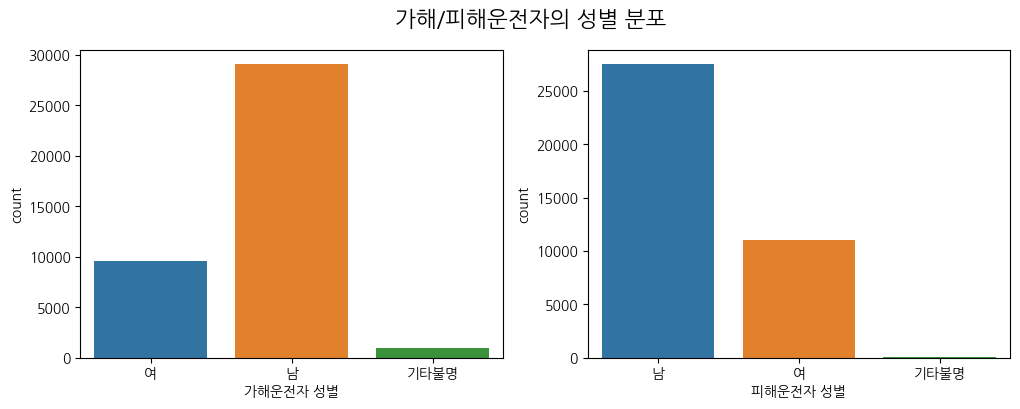

In [ ]:
plt.figure(figsize=(12, 4))
plt.suptitle('가해/피해운전자의 성별 분포', fontsize=16)
plt.subplot(1, 2, 1)
sns.countplot(data=temp_train_df, x='가해운전자 성별')
plt.subplot(1, 2, 2)
sns.countplot(data=temp_train_df, x='피해운전자 성별')

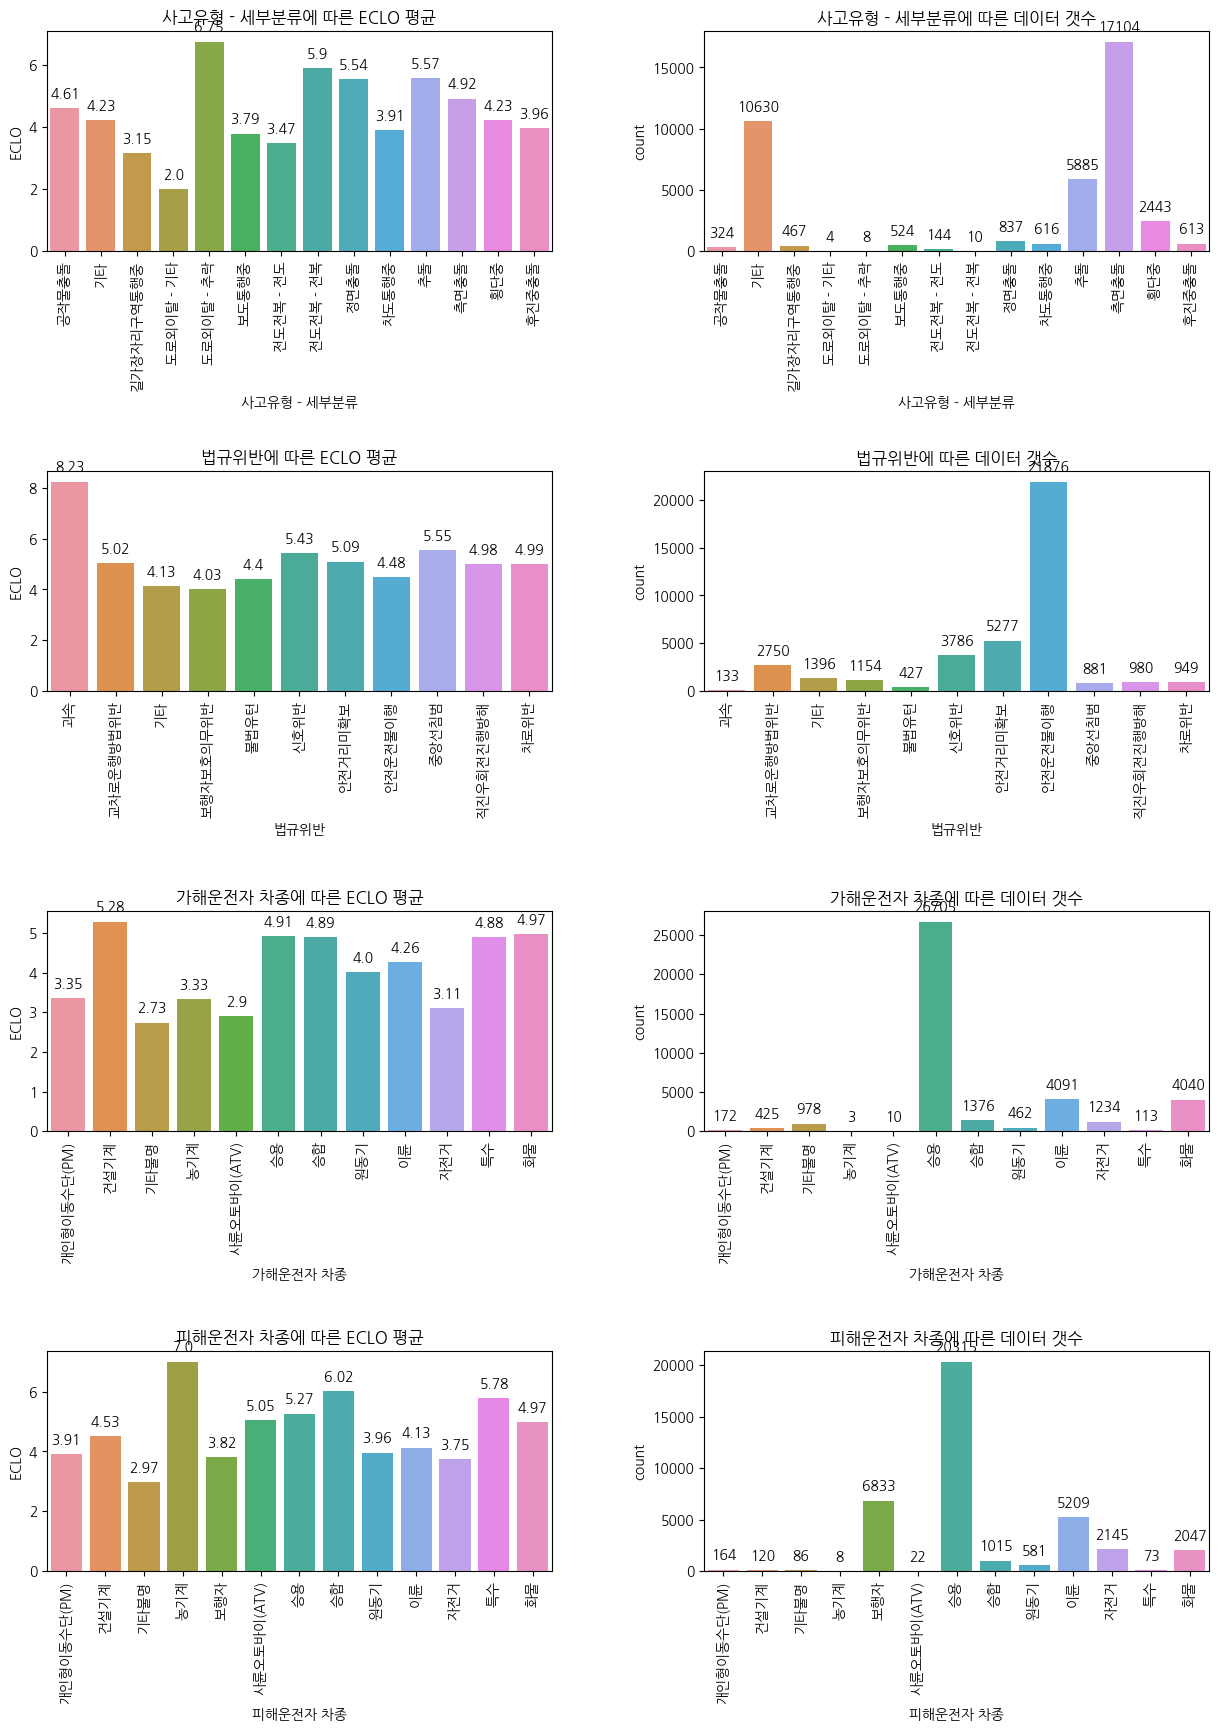

In [ ]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(['사고유형 - 세부분류', '법규위반', '가해운전자 차종', '피해운전자 차종']):
  temp_train_df = temp_train_df.sort_values(col)
  plt.subplot(4, 2, i*2+1)
  plt.title(f'{col}에 따른 ECLO 평균')
  plt.xticks(rotation=90)
  ax1 = sns.barplot(data=temp_train_df, x=col, y='ECLO', errorbar=None)
  for p in ax1.patches:
        ax1.annotate(f'{round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

  plt.subplot(4, 2, i*2+2)
  plt.title(f'{col}에 따른 데이터 갯수')
  plt.xticks(rotation=90)
  ax2 = sns.countplot(data=temp_train_df, x=col)
  for p in ax2.patches:
        ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.subplots_adjust(hspace=1, wspace=0.3)

### ***상관관계 분석해보기***
---
**Insight**
- ECLO를 구하기 위한 사망자수, 중상자수, 경상자수, 부상자수와 연관관계
  - ECLO와 경상자수, 중상자수가 연관관계가 높다.
  - ECLO와 부상자수는 음의 관계면서 연관관계가 낮다.
- train에만 있는 세부 컬럼들 간의 연관관계가 높다.
- 외부데이터끼리 연관관계가 많이 형성되어 있다.

<Axes: >

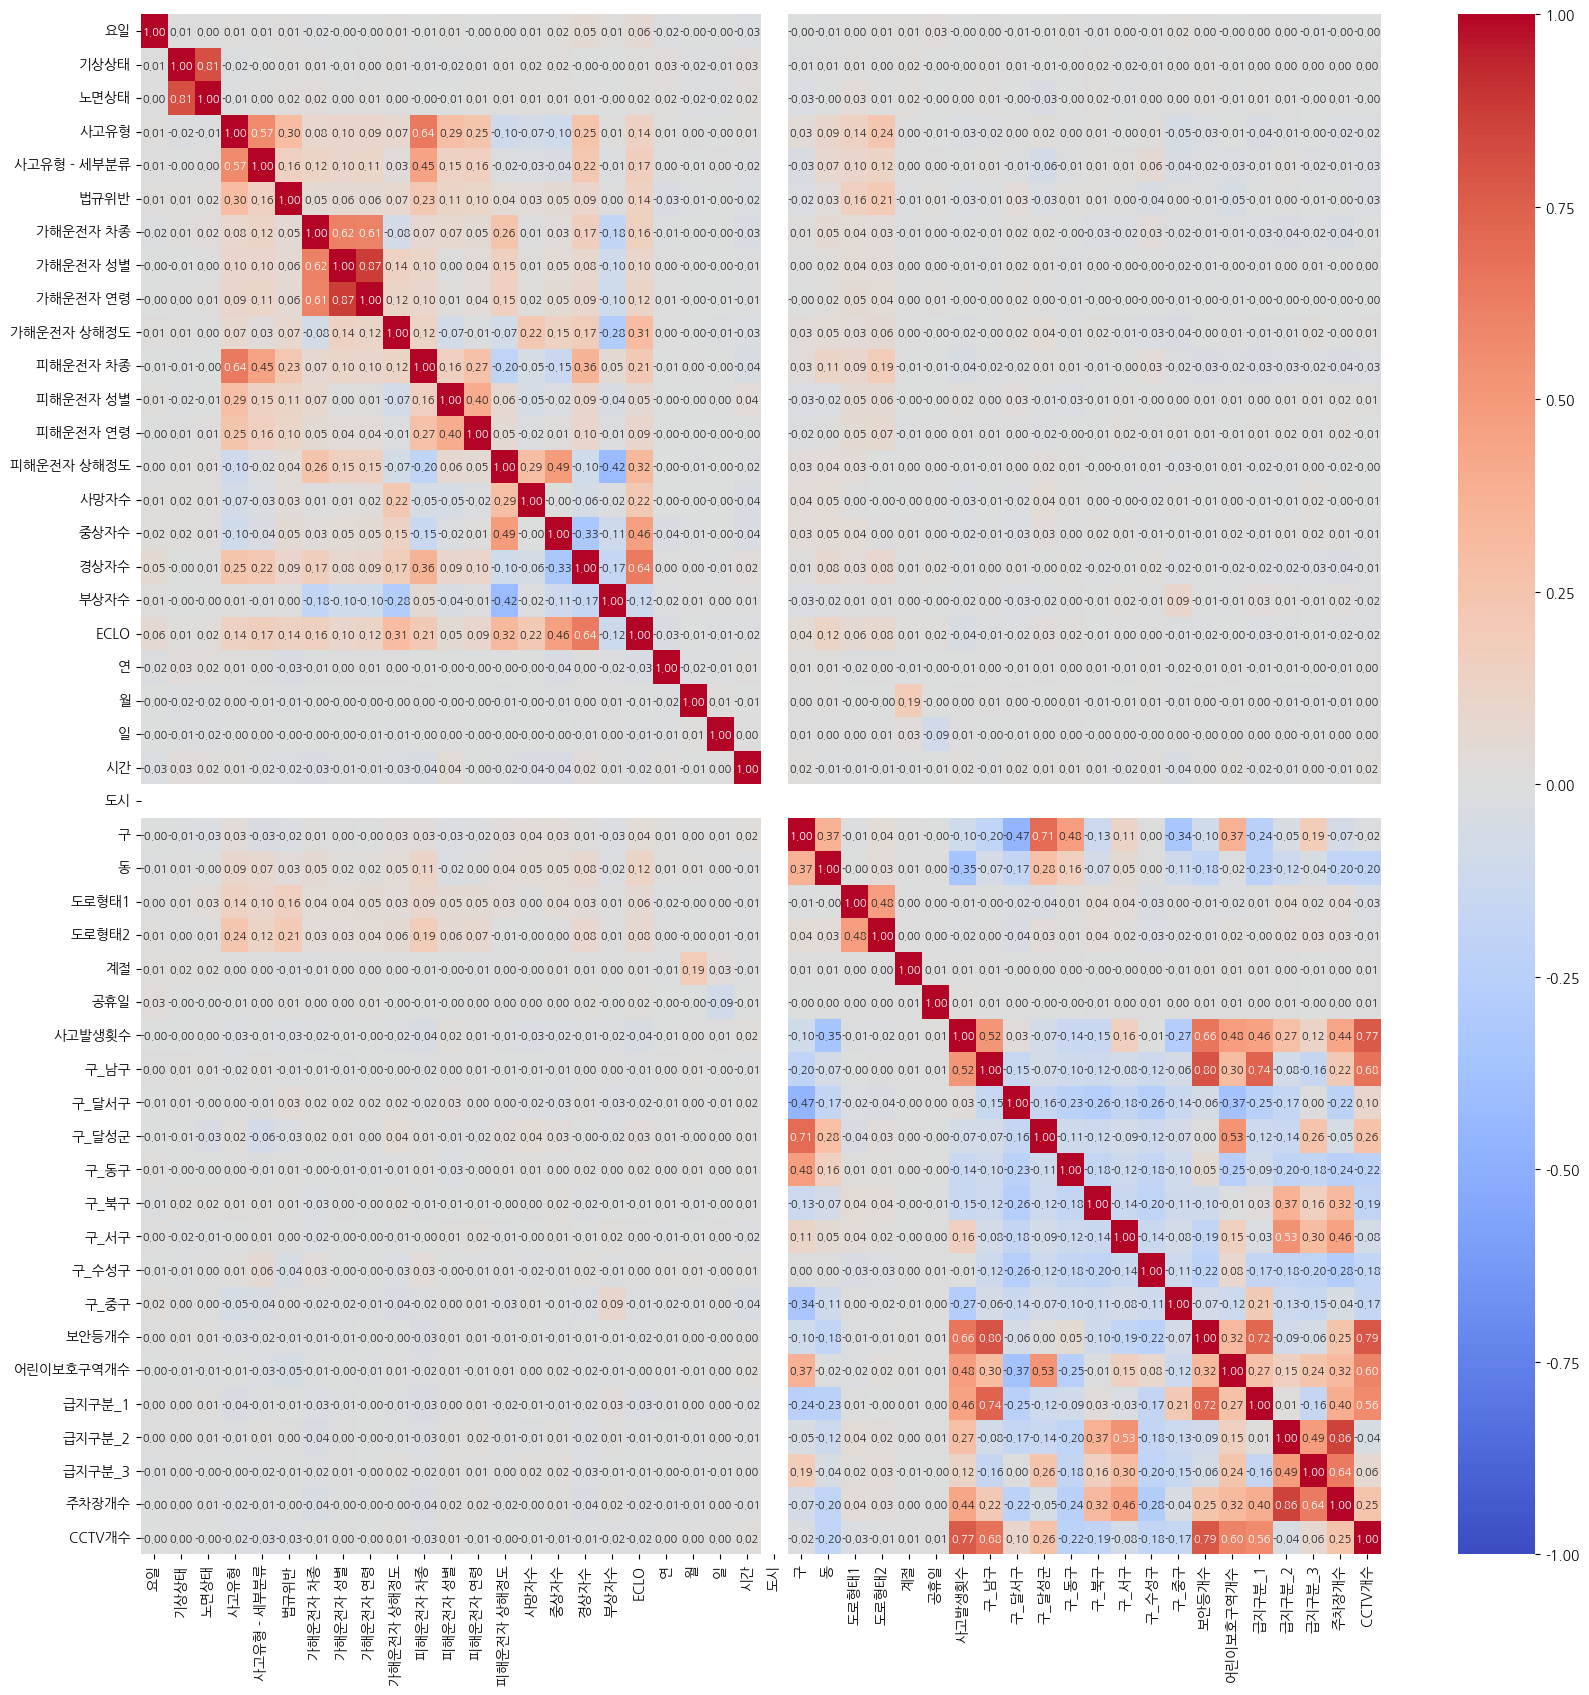

In [ ]:
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(temp_train_df.dtypes[temp_train_df.dtypes == "object"].index)
temp_train_df_le = temp_train_df.copy()
for i in categorical_features:
    # TargetEncoder
    le = TargetEncoder(cols=[i])
    temp_train_df_le[i] = le.fit_transform(temp_train_df_le[i], temp_train_df_le['ECLO'])

plt.figure(figsize=(20, 20))
temp_train_df_corr = temp_train_df_le.corr()
sns.heatmap(temp_train_df_corr, annot=True, fmt=".2f", vmin=-1, vmax=1, cmap='coolwarm', annot_kws={'size': 8})

### ***다중공선성 확인 - VIF***
---
**Insight**
- VIF가 10 이상인 컬럼을 삭제해보며, 다중공선성이 있는지 확인해보기
- '구'의 One-Hot-Encoding 8개 값은 다른 컬럼을 삭제해도 INF 값이다.
- 주차장 외부데이터에서 파생된 ('급지구분_1', '급지구분_2', '급지구분_3')와 '주차장개수'는 같이 있으면 INF 값이 뜬다.
- '도시'는 1개의 값만 존재하여 VIF 값이 항상 10보다 크다.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f"{x:.2f}")
    return vif_data

In [ ]:
# ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', '주차장개수', 'CCTV개수']
temp_train_df_le_vif = temp_train_df_le[['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수',  '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']].copy()
vif_df = calculate_vif(temp_train_df_le_vif)
print(vif_df)

      feature         VIF
0          요일        1.00
1        기상상태        2.94
2        노면상태        2.95
3        사고유형        1.07
4           연        1.00
5           월        1.04
6           일        1.01
7          시간        1.00
8          도시  6125649.99
9           구        1.52
10          동        1.35
11      도로형태1        1.31
12      도로형태2        1.36
13         계절        1.04
14        공휴일        1.01
15     사고발생횟수        3.19
16      보안등개수        3.02
17  어린이보호구역개수        2.46
18      주차장개수        1.38
19     CCTV개수        5.45


## **🚦 Preparing for Train** <a name="section-6"></a>

### **✅ 사용할 변수 정하기**

- 현재 파생 변수, 외부 데이터 등 모든 컬럼이 포함된 상태이다.
- 사용하지 않은 컬럼들을 삭제(drop)하고, 사용할 컬럼들을 출력해서 확인해보자.

In [ ]:
# test에 없는 값이 포함된 행 지우기
print('train에만 있는 동: ', (set(train_df['동'].unique())-set(test_df['동'].unique())))
train_df_len = len(train_df)
train_df = train_df[train_df['동'] != '둔산동']
train_df = train_df[train_df['동'] != '장관동']
train_df = train_df[train_df['동'] != '도남동']
train_df = train_df[train_df['동'] != '내동']
train_df = train_df[train_df['동'] != '신무동']
train_df = train_df[train_df['동'] != '서야동']

train_df = train_df[train_df['기상상태'] != '안개']
print('삭제된 행 갯수 :', train_df_len-len(train_df))

train에만 있는 동:  {'장관동', '내동', '도남동', '신무동', '서야동', '둔산동'}
삭제된 행 갯수 : 34


<a name="feature"></a>

In [ ]:
display(test_df.columns)  # 전체 컬럼 출력

Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
       '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군',
       '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1',
       '급지구분_2', '급지구분_3', '주차장개수', 'CCTV개수'],
      dtype='object')

In [ ]:
# TODO: 제거할 컬럼 추가
test_x = test_df.drop(columns=['ID', '구', '도시', '월', '급지구분_1',
       '급지구분_2', '급지구분_3', 'CCTV개수', '계절',
       '공휴일', '사고발생횟수', '보안등개수', '어린이보호구역개수']).copy()

# 사용할 컬럼 출력
display(test_x.columns)

Index(['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2',
       '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구',
       '주차장개수'],
      dtype='object')

### **train, test 데이터의 독립변수, 종속 변수 분리**

모델 추론 시점에서 획득할 수 있는 데이터는 학습 시점에서 활용할 수 있는 데이터와 다를 수 있다.  
여기서 test 시점에서만 활용할 수 있는 데이터들(test의 column들)만 사용하여 train 데이터를 구성한다.  

train_df 중에서 test_x가 가진 column들만 추출하여 train_x(독립변수)를 구성하고,   
train_df 중에서 예측 목표인 ECLO를 추출하여 train_y(종속변수)를 구성한다.

In [ ]:
train_x = train_df[test_x.columns].copy()
train_y = train_df['ECLO'].copy()

train_x.head()

,요일,기상상태,노면상태,사고유형,연,일,시간,동,도로형태1,도로형태2,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,주차장개수
0,화요일,맑음,건조,차대사람,2019,1,0,대신동,단일로,기타,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11
1,화요일,흐림,건조,차대사람,2019,1,0,감삼동,단일로,기타,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,화요일,맑음,건조,차대사람,2019,1,1,두산동,단일로,기타,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,화요일,맑음,건조,차대차,2019,1,2,복현동,단일로,기타,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14
4,화요일,맑음,건조,차대차,2019,1,4,신암동,단일로,기타,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


### **범주형(Categorical) 변수, 수치형 변수로 변환하기**

모델 학습을 위해 train_x의 문자열 타입의 컬럼들을 추출하고, TargetEncoder 혹은 LabelEncoder를 활용하여 이 컬럼들을 모두 수치형 변수로 변환한다.  
-> 여기서는 TargetEncoder를 사용하였다.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder

categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)

for i in categorical_features:
    # TargetEncoder
    le = TargetEncoder(cols=[i])
    train_x[i] = le.fit_transform(train_x[i], train_y)
    test_x[i] = le.transform(test_x[i])

    # LabelEncoder
    # le = LabelEncoder()
    # le=le.fit(train_x[i])
    # train_x[i]=le.transform(train_x[i])
    # print(f'{i} : {dict(zip(le.classes_, le.transform(le.classes_)))}')

    # for case in np.unique(test_x[i]):
    #     if case not in le.classes_:
    #         le.classes_ = np.append(le.classes_, case)
    # test_x[i]=le.transform(test_x[i])

display(train_x.head())
display(test_x.head())

,요일,기상상태,노면상태,사고유형,연,일,시간,동,도로형태1,도로형태2,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,주차장개수
0,4.626747,4.711915,4.711911,3.817077,2019,1,0,4.282449,4.669835,4.597547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11
1,4.626747,4.779150,4.711911,3.817077,2019,1,0,4.738938,4.669835,4.597547,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,4.626747,4.711915,4.711911,3.817077,2019,1,1,4.842715,4.669835,4.597547,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,4.626747,4.711915,4.711911,4.943521,2019,1,2,4.208920,4.669835,4.597547,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,14
4,4.626747,4.711915,4.711911,4.943521,2019,1,4,4.549091,4.669835,4.597547,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


,요일,기상상태,노면상태,사고유형,연,일,시간,동,도로형태1,도로형태2,구_남구,구_달서구,구_달성군,구_동구,구_북구,구_서구,구_수성구,구_중구,주차장개수
0,4.921489,4.711915,4.711911,3.817077,2022,1,1,4.881657,4.882466,5.006146,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,4.921489,4.711915,4.711911,3.817077,2022,1,1,4.563008,4.669835,4.597547,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
2,4.921489,4.711915,4.711911,4.943521,2022,1,4,4.945578,4.882466,5.006146,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,4.921489,4.711915,4.711911,4.943521,2022,1,4,4.433962,4.669835,4.597547,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
4,4.921489,4.711915,4.711911,4.943521,2022,1,6,4.738938,4.882466,5.006146,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4


## **🚀 Model Train & Prediction (DL)** <a name="section-7"></a>
- 딥러닝 실험 진행해보기

In [ ]:
def rmsle(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    squared_error = tf.square(tf.math.log1p(y_pred) - tf.math.log1p(y_true))
    return tf.sqrt(tf.reduce_mean(squared_error))

def loss_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def loss_fn_huber(y_true, y_pred, sample_weight=None):
    huber_loss = tf.keras.losses.Huber(delta=2.7)
    # 가중치 적용 할 때, 차원 다르면 동일하게 변경
    if sample_weight is not None and sample_weight.shape[0] != y_pred.shape[0]:
        sample_weight = np.expand_dims(sample_weight, axis=1)
    # 가중치 적용하여 loss 값 반환
    if sample_weight is not None:
        return huber_loss(y_true, y_pred, sample_weight)
    # 가중치 적용 안 할 때
    return huber_loss(y_true, y_pred)

def metric_fn(y_true, y_pred):
    return rmsle(y_true, y_pred)

def draw_plot(history):
    # train loss, val loss 시각화
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b-', label='train_loss')
    plt.plot(history.history['val_loss'], 'r--', label='val_loss')
    plt.xlabel('Epoch')
    plt.legend()
    # train rmlse, val rmlse 시각화
    plt.subplot(1, 2, 2)
    plt.plot(history.history['metric_fn'], 'b-', label='train_rmlse')
    plt.plot(history.history['val_metric_fn'], 'r--', label='val_rmlse')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

def make_markdown_table(history, best_check=None):
    # history 객체에서 필요한 정보 추출
    history_dict = history.history
    val_metric_fn = f"{history_dict['val_metric_fn'][-1]:.6f}"
    if best_check == True:  # font color 설정해주기
        val_metric_fn = "<font color='blue'>"+str(val_metric_fn)+"</font>"
    # 필요한 값들을 DataFrame으로 정리
    result_df = pd.DataFrame({
        'Epoch': [len(history_dict['loss'])],
        'loss': [history_dict['loss'][-1]],
        'metric_fn': [history_dict['metric_fn'][-1]],
        'val_loss': [history_dict['val_loss'][-1]],
        'val_metric_fn': [val_metric_fn]
    })
    # 결과를 마크다운 표로 출력
    markdown_table = result_df.to_markdown(index=False)
    return str(markdown_table)

### **Train & Evaluation**   
- [✅ Feature 선택하러가기](#feature)

In [ ]:
from tensorflow.keras.optimizers.schedules import CosineDecay
def create_model(weight=None):
    initializer = tf.keras.initializers.GlorotUniform(seed=seed_number)   # 시드설정추가 - Dense에 kernel_initializer 추가

    input_layer = tf.keras.Input(shape=(len(train_x.columns), ))
    x = tf.keras.layers.BatchNormalization(epsilon=0.001)(input_layer)

    x = tf.keras.layers.Dense(512, activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=0.001)(x)

    x = tf.keras.layers.Dense(256, activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=0.001)(x)

    x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.BatchNormalization(epsilon=0.001)(x)
    output_layer = tf.keras.layers.Dense(1, kernel_initializer=initializer)(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_warmup_decayed_fn),
                  loss=lambda y_true, y_pred: loss_fn_huber(y_true, y_pred, weight),
                  metrics=[metric_fn]
                  )

    return model

Epoch 1/300
1114/1114 [==============================] - 10s 8ms/step - loss: 9.0398 - metric_fn: nan - val_loss: 7.3522 - val_metric_fn: nan
Epoch 2/300
1114/1114 [==============================] - 6s 6ms/step - loss: 6.9972 - metric_fn: nan - val_loss: 4.5982 - val_metric_fn: nan
Epoch 3/300
1114/1114 [==============================] - 8s 7ms/step - loss: 4.5992 - metric_fn: nan - val_loss: 3.0271 - val_metric_fn: 0.4599
Epoch 4/300
1114/1114 [==============================] - 7s 6ms/step - loss: 3.6607 - metric_fn: nan - val_loss: 2.7921 - val_metric_fn: 0.4305
Epoch 5/300
1114/1114 [==============================] - 8s 8ms/step - loss: 3.3948 - metric_fn: nan - val_loss: 2.7511 - val_metric_fn: 0.4261
Epoch 6/300
1114/1114 [==============================] - 7s 6ms/step - loss: 3.2525 - metric_fn: 0.4805 - val_loss: 2.7421 - val_metric_fn: 0.4251
Epoch 7/300
1114/1114 [==============================] - 7s 6ms/step - loss: 3.1698 - metric_fn: 0.4677 - val_loss: 2.7267 - val_metric_fn

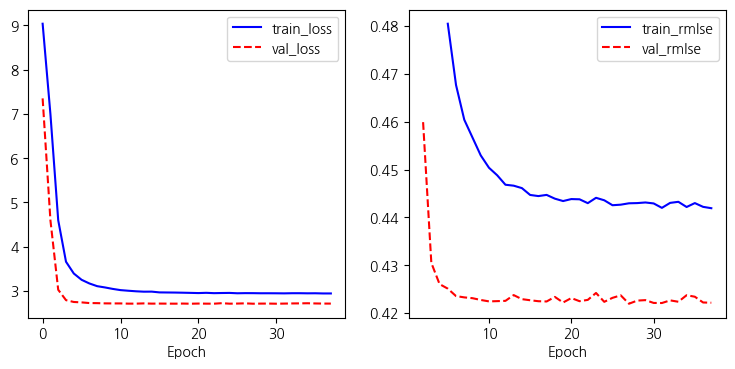

In [ ]:
model_name = 'DL'   # submission 파일 이름용

callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_metric_fn', patience=10, verbose=2, mode='min',restore_best_weights=True),
    #tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

# Hyperparameters
total_steps = len(train_x)
decay_steps = 500
initial_learning_rate = 0.0
warmup_steps = 40000
target_learning_rate = 5e-3
lr_warmup_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, decay_steps, warmup_target=target_learning_rate,
    warmup_steps=warmup_steps
)

# 가중치 부여 - 19 이상인 값에 대해 가중치 2.0, 그 외에는 1.0
more_weight = np.where(train_y >= 19, 2.0, 1.0)
more_weight = np.expand_dims(more_weight, axis=1)
# model = create_model(weight=more_weight)

model = create_model()
history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                    epochs=300,
                    callbacks=callbacks_list,
                    validation_split=0.1)


s = f"*Columns: {list(train_x.columns)}\n\n"
s += make_markdown_table(history) + '\n'  # 기록용 마크다운표 출력 함수
print(s)
draw_plot(history)                        # plot 그리기

### **조합 자동화 실험 및 결과 저장**
파생변수 + 외부데이터 실험 시 자동화로 간편하게 기록하고자 코드를 구현하였다.

In [ ]:
# test_df의 모든 컬럼
# ['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',
#        '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군',
#        '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1',
#        '급지구분_2', '급지구분_3', '주차장개수', 'CCTV개수']

from itertools import combinations
import sys
import os

# 기본 컬럼, 외부 데이터 컬럼, 파생 변수 컬럼 정의
basic_elements = ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2']
derived_variables = ['계절', '공휴일', '사고발생횟수', ('구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구')]
external_elements = ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '주차장개수', 'CCTV개수']


# ============================== TODO ==============================
# TODO: 기존 삭제할 컬럼들 ('ID'는 필수값)
remove_elements = ['ID', '구', '도시', '월', '계절', '공휴일', '사고발생횟수']

# TODO: 추가 조합 실험해볼 컬럼들 -> remove_elements 리스트 값과 겹치면 안됨
add_elements = ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '주차장개수', 'CCTV개수']

# TODO: 기록 시작 숫자
start_number = 1

# TODO: 결과를 저장할 폴더 및 파일명 설정
folder_path = 'exp'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
output_file_path = f'{folder_path}/exp_results1.txt'
best_rmlse_file_path = f'{folder_path}/best_rmlse.txt'
# ==================================================================


# 중복되지 않게 설정할 2개값 - (여러컬럼,1개컬럼) or (1개컬럼, 1개컬럼)
one_of_select1 = [('급지구분_1', '급지구분_2', '급지구분_3'), '주차장개수']
one_of_select2 = [('구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구'), '구']
one_of_select3 = ['계절', '월']

check = list(set(remove_elements).intersection(add_elements))
if check:
    print(f'remove_elements와 add_elements에 중복되는 컬럼 : {check}')
    sys.exit("컬럼을 다시 설정해주세요")


# train에만 있는 '동' 6개와 '안개(기상상태)'를 삭제했는지 확인
train_test_same_check = (len(set(train_df['동'].unique())-set(test_df['동'].unique())) == 0) and (len(train_df[train_df['기상상태'] == '안개']) == 0)
best_score = 1e9    # 목표는 rmlse의 최솟값이기 때문

for combi_number in range(1, len(add_elements)+1):
    combinations_list = list(combinations(add_elements, combi_number))
    for i, combination in enumerate(combinations_list):
        # 저장된 Best Score 값 가져오기
        try:
          with open(best_rmlse_file_path, 'r', encoding='utf-8') as file:   # 파일에 결과값 추가하기
              best_score = float(file.read())
              print(f'파일에서 가져온 Best Score(RMLSE): {best_score}')
        except FileNotFoundError:
          print('저장된 Best Score 값이 없습니다.')

        print(f'{"="*40} 실험 # {(i+1)} / {len(combinations_list)} {"="*40}')
        combi_columns = list(combination)
        print(f'>> 현재 선택된 조합: {combi_columns}')

        # ============================== TODO ==============================
        # 선택된 조합이 one_of_select 라면 패스 (중복 가능하게 하려면 주석처리 할 것)
        if all(j in combi_columns for j in one_of_select1):
            print('>> one_of_select1')
            continue
        if all(j in combi_columns for j in one_of_select2):
            print('>> one_of_select2')
            continue
        if all(j in combi_columns for j in one_of_select3):
            print('>> one_of_select3')
            continue
        # ==================================================================

        combi_columns_exc = list(set(add_elements)-set(combi_columns))  # 선택조합 외 리스트값
        drop_columns = []+remove_elements   # 삭제될 컬럼들
        for item in combi_columns_exc:
            if isinstance(item, tuple): # 튜플을 리스트로
                drop_columns.extend(list(item))
            else:
                drop_columns.append(item)

        test_x = test_df.drop(columns=list(set(drop_columns))).copy()
        display(test_x.columns)   # 사용할 컬럼 출력

        train_x = train_df[test_x.columns].copy()
        train_y = train_df['ECLO'].copy()
        categorical_features = list(train_x.dtypes[train_x.dtypes == "object"].index)
        for j in categorical_features:
            le = TargetEncoder(cols=[j])
            train_x[j] = le.fit_transform(train_x[j], train_y)
            test_x[j] = le.transform(test_x[j])

        model = create_model()
        history = model.fit(train_x.astype('float32'), train_y.astype('float32'),
                            epochs=300,
                            callbacks=callbacks_list,
                            validation_split=0.1)

        remove_list = list(set(basic_elements).intersection(remove_elements))
        dv_list = list(set(derived_variables).intersection(train_x.columns))
        external_list = list(set(external_elements).intersection(train_x.columns))

        dataset_print_list = []
        if train_test_same_check:
            dataset_print_list.append('파생변수#2')
        if len(remove_list) != 0:
            remove_str = f'{remove_list} 컬럼 삭제'
            dataset_print_list.append(remove_str)
        if (sum(1 for i in train_x.columns if i.startswith('구_')) == 8):
            dv_list.append(derived_variables[3])
            dv_list = list(set(dv_list))
        if len(dv_list) != 0:
            if derived_variables[3] in dv_list:   # '구' one-hot-encoding 8개
                dv_list.remove(derived_variables[3])
                dv_str1 = "['구' one-hot-encoding 8개] 추가"
                dataset_print_list.append(dv_str1)
        if (sum(1 for i in train_x.columns if i.startswith('급지구분_')) == 3):
            external_list.append(external_elements[2])
            external_list = list(set(external_list))
        if len(external_list) != 0:
            external_str = f'{external_list} 컬럼 추가'
            dataset_print_list.append(external_str)
        if len(dv_list) != 0:
            dv_str2 = f'{dv_list} 컬럼 추가'
            dataset_print_list.append(dv_str2)

        score = history.history['val_metric_fn'][-1]
        if score <= best_score:
          with open(best_rmlse_file_path, 'w', encoding='utf-8') as file:
              file.write(str(score))

        s = f'\n#### **#{start_number:03d}**\n'
        s += f'*Dataset: {" + ".join(dataset_print_list)}\n\n'
        s += f'*Columns: {list(train_x.columns)}\n\n'
        s += make_markdown_table(history, score <= best_score) + '\n'      # 기록용 마크다운표 출력 함수
        start_number += 1
        print(s)

        with open(output_file_path, 'a', encoding='utf-8') as file:   # 파일에 결과값 추가하기
            file.write(s)

### **실험 기록 (Feature Selection)**

#### 📑 파생변수
- **[#21💛](#exp1-21)** - <font color='blue'>0.422367</font>  
- **[#22💛](#exp1-22)** - <font color='blue'>0.422216</font>

---
#### **#1**
*Dataset: 기본 데이터셋

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      43 | 2.9441 |    0.442391 |    2.72799 |        0.423405 |

#### **#2**
*Dataset: test에 없는 '동' 6개, '안개' 행 삭제

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      41 |  2.941 |    0.442238 |    2.72146 |         <font color='blue'>0.42278</font> |


#### **#3**
*Dataset: ['도시'] 컬럼 삭제

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      36 | 2.94673 |     0.44269 |    2.73011 |        0.423767 |

#### **#4**
*Dataset: ['연'] 컬럼 삭제

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      39 | 2.94844 |     0.44325 |    2.72964 |        0.424252 |

#### **#5**
*Dataset: ['도시', '연'] 컬럼 삭제

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      36 | 2.94712 |    0.442811 |    2.73974 |        0.425456 |

#### **#6**
*Dataset: #2 + ['도시', '연'] 컬럼 삭제

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94602 |     0.44214 |    2.71747 |        0.423056 |

---
#### **#7**
*Dataset: #2 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '계절']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94089 |    0.442183 |    2.72048 |        0.422787 |

#### **#8**
*Dataset: #2 + ['계절'] 컬럼 추가 + ['월'] 컬럼 삭제

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '계절']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94266 |    0.441691 |     2.7189 |        0.422789 |


#### **#9**
*Dataset: #2 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '공휴일']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94005 |    0.442109 |    2.72111 |        <font color='blue'>0.422752</font> |

#### **#10**
*Dataset: #2 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '계절', '공휴일']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94701 |    0.442097 |    2.72439 |        0.423715 |

#### **#11**
*Dataset: #2 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '사고발생횟수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      41 | 2.9405 |    0.442243 |     2.7185 |        <font color='blue'>0.422677</font> |

#### **#12**
*Dataset: #2 + ['공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94655 |    0.442015 |    2.72425 |        0.423818 |

#### **#13**
*Dataset: #2 + ['계절', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94699 |    0.442071 |     2.7224 |        0.423731 |

#### **#14**
*Dataset: #2 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94676 |    0.442055 |    2.72397 |        0.423806 |

---
#### **#15**
*Dataset: #2 + ['구'] 삭제 + ['구' one-hot-encoding 8개] 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      42 |  2.939 |    0.441847 |    2.72037 |        <font color='blue'>0.422635</font> |

#### **#16**
*Dataset: #2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93959 |    0.441996 |    2.71946 |        <font color='blue'>0.422551</font> |


#### **#17**
*Dataset: #2 + ['구', '도시', '연'] 삭제 + ['구' one-hot-encoding 8개] 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94576 |     0.44207 |    2.71629 |        0.422858 |

#### **#18**
*Dataset: #2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['사고발생횟수'] 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94601 |    0.442043 |    2.72121 |        0.423255 |

#### **#19**
*Dataset: #2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['공휴일'] 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94156 |    0.441445 |    2.72472 |        0.423059 |


#### **#20**
*Dataset: #2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['계절'] 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      41 | 2.9399 |    0.442066 |    2.72295 |        0.422868 |

---

#### **#21💛** <a name="exp1-21"></a>
*Dataset: 파생변수#2 + ['구', '도시', '월'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94488 |    0.441922 |    2.71612 |        <font color='blue'>0.422367</font> |

#### **#22💛** <a name="exp1-22"></a>
*Dataset: 파생변수#2 + ['구', '도시', '월'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['계절', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94227 |    0.441685 |    2.71377 |        <font color='blue'>0.422216</font> |

#### **#23**
*Dataset: 파생변수#2 + ['구', '도시', '월'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94121 |     0.44212 |    2.71712 |        0.422453 |

#### **#24**
*Dataset: 파생변수#2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94156 |    0.441445 |    2.72472 |        0.423059 |

#### **#25**
*Dataset: 파생변수#2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94601 |    0.442043 |    2.72121 |        0.423255 |

---

#### **#26**
*Dataset: 파생변수#2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94106 |    0.441438 |    2.72264 |        0.422983 |

#### **#27**
*Dataset: 파생변수#2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['계절', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94192 |     0.44158 |    2.71992 |        0.422782 |

#### **#28**
*Dataset: 파생변수#2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94185 |    0.441549 |    2.72329 |        0.422991 |

#### **#29**
*Dataset: 파생변수#2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93874 |    0.441914 |    2.72383 |        0.422955 |


---

#### **#30**
*Dataset: 파생변수#2 + ['구', '도시', '월'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94322 |    0.441719 |    2.71771 |        0.422535 |

#### **#31**
*Dataset: 파생변수#2 + ['구', '도시'] 삭제 + ['구' one-hot-encoding 8개] 추가 + ['공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94185 |    0.441549 |    2.72329 |        0.422991 |

---

#### 📑 외부데이터
- '보안등개수' + ('급지구분_1', '급지구분_2', '급지구분_3') : 시너지 좋음
- '보안등개수' + '어린이보호구역개수' : 시너지 나쁨
- **[#17💛](#exp2-17)** - <font color='blue'>0.422561</font>
  - ['보안등개수', '어린이보호구역개수', '주차장개수'] : 2개씩 결합은 시너지 안좋았는데, 3개 결합헀을때 시너지가 좋아졌다.
  - 파생변수도 추가했을때 가장 베스트
- **[#18💛](#exp2-18)** - <font color='blue'>0.422517</font>
  - ['보안등개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] : 시너지 가장 좋은 결합
---
#### **#1**
*Dataset: 파생변수#2 + ['보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94029 |    0.442133 |    2.72002 |        0.422699 |

#### **#2**
*Dataset: 파생변수#2 + ['어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94082 |     0.44223 |    2.71952 |        0.422703 |

#### **#3**
*Dataset: 파생변수#2 + ['CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93991 |    0.442156 |    2.71875 |        0.422606 |

#### **#4**
*Dataset: 파생변수#2 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94274 |    0.441663 |    2.72033 |        0.422802 |

#### **#5**
*Dataset: 파생변수#2 + ['주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '주차장개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9446 |    0.441913 |    2.71876 |        0.422693 |

---
#### **#6**
*Dataset: 파생변수#2 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94378 |    0.441834 |    2.71958 |        0.422737 |

#### **#7**
*Dataset: 파생변수#2 + ['보안등개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94086 |    0.442217 |    2.72004 |        0.422649 |

#### **#8**
*Dataset: 파생변수#2 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94013 |    0.442064 |    2.71986 |         0.42262 |

#### **#9**
*Dataset: 파생변수#2 + ['보안등개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94309 |    0.441737 |    2.71975 |        0.422799 |

#### **#10**
*Dataset: 파생변수#2 + ['어린이보호구역개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94362 |    0.441945 |    2.71841 |        <font color='blue'>0.422588</font> |

#### **#11**
*Dataset: 파생변수#2 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94028 |    0.442124 |    2.72077 |        0.422699 |

#### **#12**
*Dataset: 파생변수#2 + ['어린이보호구역개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94112 |    0.442229 |    2.71967 |        0.422754 |

#### **#13**
*Dataset: 파생변수#2 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94003 |    0.442096 |    2.72061 |        0.422941 |

#### **#14**
*Dataset: 파생변수#2 + ['CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94324 |    0.441763 |    2.71781 |        <font color='blue'>0.422592</font> |

---
#### **#15**
*Dataset: 파생변수#2 + ['보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94384 |    0.441864 |    2.71955 |        0.422684 |

#### **#16**
*Dataset: 파생변수#2 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94639 |     0.44205 |    2.72462 |        0.423988 |

#### **#17💛** <a name="exp2-17"></a>
*Dataset: 파생변수#2 + ['보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9431 |    0.441722 |    2.71877 |        <font color='blue'>0.422561</font> |

#### **#18💛** <a name="exp2-18"></a>
*Dataset: 파생변수#2 + ['보안등개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94295 |    0.441645 |    2.71828 |        <font color='blue'>0.422517</font> |

#### **#19**
*Dataset: 파생변수#2 + ['보안등개수', 'CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94327 |    0.441778 |    2.71914 |        0.422702 |

#### **#20**
*Dataset: 파생변수#2 + ['어린이보호구역개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94338 |    0.441724 |    2.71774 |        <font color='blue'>0.422534</font> |

#### **#21**
*Dataset: 파생변수#2 + ['어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94384 |     0.44184 |    2.71916 |        0.422691 |

---
#### **#22**
*Dataset: 파생변수#2 + ['보안등개수', '어린이보호구역개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94626 |    0.442039 |    2.72133 |        0.423575 |

#### **#23**
*Dataset: 파생변수#2 + ['보안등개수', '어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94051 |    0.442158 |    2.71872 |        0.422631 |

---
- ['도시'] 컬럼 삭제 + 4개 컬럼 추가

#### **#24**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['보안등개수', '어린이보호구역개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94361 |     0.44173 |    2.71912 |        0.422638 |

#### **#25**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['보안등개수', '어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94409 |    0.441827 |    2.71963 |        0.422709 |

---
- ['도시'] 컬럼 삭제 + 3개 컬럼 추가

#### **#26**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      54 | 2.94018 |    0.441036 |     2.7198 |         0.42271 |

#### **#27**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94057 |    0.442115 |    2.72109 |        0.422781 |

#### **#28**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94121 |    0.442251 |    2.72037 |        0.422736 |

#### **#29**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['보안등개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94433 |     0.44179 |    2.72108 |        0.422872 |

#### **#30**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['보안등개수', 'CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94315 |    0.441701 |    2.72017 |        0.422887 |

#### **#31**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['어린이보호구역개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94523 |    0.441877 |    2.72109 |        0.422805 |

#### **#32**
*Dataset: 파생변수#2 + ['도시'] 컬럼 삭제 + ['어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      54 | 2.94008 |    0.441021 |    2.71891 |        0.422619 |

---

- ['도시', '연'] 컬럼 삭제 + 3개 컬럼 추가

#### **#33**
*Dataset: 파생변수#2 + ['도시', '연'] 컬럼 삭제 + ['보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94509 |    0.442002 |    2.71654 |        0.422968 |

#### **#34**
*Dataset: 파생변수#2 + ['도시', '연'] 컬럼 삭제 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94503 |    0.442015 |     2.7158 |        0.423029 |

#### **#35**
*Dataset: 파생변수#2 + ['도시', '연'] 컬럼 삭제 + ['보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94512 |    0.441968 |    2.71644 |        0.422997 |

#### **#36**
*Dataset: 파생변수#2 + ['도시', '연'] 컬럼 삭제 + ['보안등개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94451 |    0.441943 |    2.71736 |        0.423235 |

#### **#37**
*Dataset: 파생변수#2 + ['도시', '연'] 컬럼 삭제 + ['보안등개수', 'CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94468 |    0.441961 |    2.71599 |        0.422982 |

#### **#38**
*Dataset: 파생변수#2 + ['도시', '연'] 컬럼 삭제 + ['어린이보호구역개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94412 |    0.441885 |    2.71724 |        0.423215 |

#### **#39**
*Dataset: 파생변수#2 + ['도시', '연'] 컬럼 삭제 + ['어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '월', '일', '시간', '구', '동', '도로형태1', '도로형태2', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94486 |    0.441974 |    2.71583 |        0.422991 |

---

#### 📑 파생변수 + 외부데이터
- **[#004💜](#exp3-004)** - <font color='blue'>0.422168</font>

- **[#014💜](#exp3-014)** - <font color='blue'>0.422202</font>

---
- '구' one-hot-encoding 8개 + 외부데이터

#### **#001**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94345 |    0.441921 |    2.71637 |        0.422483 |

#### **#002**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94373 |    0.441892 |    2.71502 |         0.42226 |

#### **#003**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94381 |    0.441914 |     2.7156 |        0.422457 |

#### **#004💜** <a name="exp3-004"></a>
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss | val_metric_fn                      |
|--------:|--------:|------------:|-----------:|:-----------------------------------|
|      38 | 2.94385 |    0.441918 |    2.71485 |        <font color='blue'>0.422168</font> |

#### **#005**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94235 |    0.441737 |    2.71649 |        0.422463 |


#### **#006**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94332 |    0.441873 |    2.71547 |        0.422402 |

#### **#007**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94373 |    0.441906 |    2.71658 |        0.422475 |

#### **#008**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94359 |    0.441864 |    2.71487 |        0.422411 |

#### **#009**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94471 |       0.442 |    2.71549 |        0.422281 |

#### **#010**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94396 |    0.441876 |    2.71571 |          0.4223 |

#### **#011**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94211 |    0.442211 |    2.71614 |        0.422549 |

#### **#012**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94446 |    0.441956 |    2.71482 |        0.422203 |




#### **#013**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94391 |    0.441913 |    2.71723 |        0.422501 |

#### **#014💜** <a name="exp3-014"></a>
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94332 |    0.441868 |    2.71463 |        <font color='blue'>0.422202</font> |

#### **#015**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94433 |    0.441944 |    2.71615 |        0.422343 |

#### **#016**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94403 |     0.44191 |    2.71523 |        0.422492 |

#### **#017**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94412 |    0.441932 |    2.71596 |         0.42244 |

#### **#18**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      48 | 2.94389 |    0.442163 |    2.71547 |        0.422433 |

#### **#019**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94467 |    0.441992 |     2.7153 |        0.422344 |

#### **#020**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94341 |    0.441852 |    2.71571 |        0.422321 |

#### **#021**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      48 | 2.94397 |     0.44216 |    2.71578 |         0.42242 |

#### **#022**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94463 |    0.441978 |    2.71808 |        0.422582 |

#### **#023**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '주차장개수', '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94206 |    0.442196 |     2.7163 |          0.4225 |

---

- '구' one-hot-encoding 8개 + 외부데이터 + 계절/공휴일/사고발생횟수

스토리지의 94% 사용됨 … 소진 시 스토리지가 부족해 파일을 만들거나 수정하거나 업로드할 수 없게 됩니다. 3개월 동안 100GB 스토리지를 월 ₩2,400 ₩600에 이용하세요.
#### **#024**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94395 |    0.441847 |    2.71619 |        0.422377 |

#### **#025**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94366 |    0.441835 |    2.71636 |        0.422345 |

#### **#026**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94529 |    0.442036 |    2.71695 |        0.422583 |

#### **#027**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94355 |    0.441784 |    2.71652 |        0.422314 |

#### **#028**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94324 |     0.44179 |    2.71555 |        0.422239 |

#### **#029**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94331 |    0.441867 |    2.71547 |        0.422395 |

#### **#030**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94507 |    0.441949 |    2.71797 |        0.422681 |

#### **#031**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94331 |    0.441801 |    2.71628 |        0.422398 |

#### **#032**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94397 |    0.441891 |    2.71596 |         0.42245 |

#### **#033**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94481 |    0.441913 |     2.7177 |         0.42252 |

#### **#034**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94348 |    0.441787 |    2.71705 |        0.422489 |

#### **#035**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94351 |    0.441801 |    2.71643 |        0.422418 |

#### **#036**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94522 |     0.44203 |    2.71694 |        0.422556 |

#### **#037**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94404 |    0.441914 |    2.71672 |         0.42254 |

#### **#038**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94517 |    0.442022 |    2.71604 |        0.422511 |

#### **#039**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94392 |    0.441925 |    2.71609 |        0.422567 |

#### **#040**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94351 |    0.441867 |    2.71568 |        0.422458 |

#### **#041**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94148 |    0.442213 |    2.71753 |        0.422722 |

#### **#042**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94405 |     0.44188 |    2.71582 |         0.42243 |

#### **#043**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94155 |     0.44222 |    2.71763 |        0.422713 |

#### **#044**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94362 |    0.441854 |    2.71621 |        0.422576 |

#### **#045**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94442 |     0.44194 |    2.71555 |        0.422442 |

#### **#046**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      51 | 2.94728 |    0.442464 |     2.7142 |        0.422339 |

#### **#047**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95499 |    0.444107 |    2.71992 |        0.423713 |

#### **#048**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      50 | 2.9425 |    0.441618 |    2.71843 |        0.422677 |

#### **#049**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94418 |    0.441905 |    2.71953 |         0.42282 |

#### **#050**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93899 |    0.441871 |    2.71957 |        0.422686 |

#### **#051**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94207 |    0.441592 |    2.71746 |        0.422622 |

#### **#052**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94385 |    0.441856 |     2.7189 |        0.422738 |

#### **#053**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94393 |    0.441839 |    2.71856 |        0.422782 |

#### **#054**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      50 | 2.9435 |    0.441762 |    2.71763 |         0.42261 |

#### **#055**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94407 |    0.441864 |    2.71894 |         0.42274 |

#### **#056**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94283 |     0.44173 |    2.71868 |        0.422702 |

#### **#057**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94278 |     0.44168 |    2.71943 |        0.422719 |

#### **#058**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94315 |    0.441749 |    2.71924 |        0.422718 |

#### **#059**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9446 |    0.441944 |    2.71848 |        0.422669 |

#### **#060**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94022 |    0.442073 |    2.71837 |        0.422672 |

#### **#061**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      51 | 2.94615 |    0.442355 |     2.7179 |        0.422794 |

#### **#062**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94374 |    0.441833 |    2.71758 |        0.422654 |

#### **#063**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94353 |    0.441815 |    2.71787 |        0.422709 |

#### **#064**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94003 |    0.442046 |    2.71938 |        0.422839 |

#### **#065**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '보안등개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94165 |    0.442066 |    2.71831 |        0.422724 |

#### **#066**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94027 |    0.442075 |    2.71891 |        0.422853 |

#### **#067**
*Dataset: 파생변수#2 + ['월', '도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94112 |    0.442027 |     2.7184 |        0.422733 |

#### **#068**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94497 |    0.441993 |    2.71816 |        0.422676 |

#### **#069**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94266 |    0.441746 |    2.71694 |        0.422672 |

#### **#070**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95519 |    0.444215 |    2.71723 |        0.423529 |

#### **#071**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94219 |    0.441604 |    2.71456 |        0.422254 |

#### **#072**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94343 |    0.441819 |    2.71584 |        0.422519 |

#### **#073**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      51 | 2.94671 |    0.442367 |    2.71489 |         0.42237 |

#### **#074**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95414 |    0.444059 |     2.7169 |        0.423492 |

#### **#075**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94351 |    0.441829 |    2.71596 |        0.422409 |

#### **#076**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94454 |    0.441923 |    2.71555 |        0.422516 |

#### **#077**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95468 |    0.444145 |    2.71777 |        0.423493 |

#### **#078**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94372 |    0.441816 |    2.71586 |        0.422425 |

#### **#079**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94398 |    0.441845 |    2.71599 |        0.422485 |

#### **#080**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94259 |    0.441715 |    2.71542 |        0.422365 |

#### **#081**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94281 |    0.441665 |    2.71526 |          0.4224 |

#### **#082**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      27 | 2.95272 |    0.442888 |    2.72801 |        0.424784 |

#### **#083**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94103 |    0.442176 |    2.71525 |        0.422396 |

#### **#084**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      51 | 2.94779 |    0.442532 |    2.71574 |        0.422479 |

#### **#085**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94292 |     0.44172 |    2.71437 |        0.422349 |

#### **#086**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94306 |    0.441735 |    2.71588 |        0.422458 |

#### **#087**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94514 |    0.441967 |    2.71747 |        0.422675 |

#### **#088**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95513 |    0.444206 |    2.71755 |        0.423516 |

#### **#089**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94516 |    0.441957 |    2.71697 |        0.422611 |

#### **#090**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95538 |    0.444251 |    2.71821 |         0.42366 |

#### **#091**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94504 |    0.442008 |    2.71661 |        0.422571 |

#### **#092**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', 'CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95491 |     0.44416 |    2.71711 |        0.423484 |

---

#### **#093**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94495 |    0.441949 |    2.71602 |         0.42246 |

#### **#094**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94387 |    0.441827 |    2.71717 |        0.422415 |

#### **#095**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94517 |    0.441988 |    2.71849 |        0.422828 |

#### **#096**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94411 |    0.441905 |    2.71712 |        0.422507 |

#### **#097**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94395 |     0.44186 |    2.71518 |        0.422353 |

#### **#098**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94498 |    0.441932 |    2.71649 |        0.422529 |

#### **#099**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94222 |    0.442171 |    2.71709 |        0.422717 |

#### **#100**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94515 |    0.441983 |    2.71623 |        0.422542 |

#### **#101**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.93997 |    0.441984 |    2.71626 |        0.422624 |

#### **#102**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94244 |     0.44224 |    2.71524 |         0.42251 |

#### **#103**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94463 |    0.441913 |    2.71625 |        0.422491 |

#### **#104**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94367 |    0.441825 |    2.71624 |        0.422465 |

#### **#105**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94505 |    0.441979 |    2.71823 |        0.422722 |

#### **#106**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94437 |    0.441913 |    2.71725 |        0.422598 |

#### **#107**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9449 |    0.441899 |    2.71782 |        0.422658 |

#### **#108**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94494 |    0.441935 |    2.71602 |        0.422523 |

#### **#109**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94495 |    0.441931 |    2.71768 |         0.42266 |

#### **#110**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94503 |     0.44196 |    2.71736 |         0.42263 |

#### **#111**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95468 |    0.444151 |    2.71687 |        0.423378 |

#### **#112**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94288 |    0.442294 |    2.71548 |         0.42256 |

#### **#113**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94466 |    0.441912 |    2.71681 |        0.422585 |

#### **#114**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94463 |    0.441914 |    2.71741 |        0.422694 |

#### **#115**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94504 |    0.441958 |    2.71691 |        0.422574 |

---

스토리지의 94% 사용됨 … 소진 시 스토리지가 부족해 파일을 만들거나 수정하거나 업로드할 수 없게 됩니다. 3개월 동안 100GB 스토리지를 월 ₩2,400 ₩600에 이용하세요.
#### **#116**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95499 |    0.444107 |    2.71992 |        0.423713 |

#### **#117**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      50 | 2.9425 |    0.441618 |    2.71843 |        0.422677 |

#### **#118**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94418 |    0.441905 |    2.71953 |         0.42282 |

#### **#119**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93899 |    0.441871 |    2.71957 |        0.422686 |

#### **#120**
*Dataset: 파생변수#2 + ['도시', '월', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94207 |    0.441592 |    2.71746 |        0.422622 |

#### **#122**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94393 |    0.441839 |    2.71856 |        0.422782 |

#### **#123**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      50 | 2.9435 |    0.441762 |    2.71763 |         0.42261 |

#### **#124**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94407 |    0.441864 |    2.71894 |         0.42274 |

#### **#125**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94283 |     0.44173 |    2.71868 |        0.422702 |

#### **#126**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94278 |     0.44168 |    2.71943 |        0.422719 |

#### **#127**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94315 |    0.441749 |    2.71924 |        0.422718 |

#### **#128**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9446 |    0.441944 |    2.71848 |        0.422669 |

#### **#129**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94022 |    0.442073 |    2.71837 |        0.422672 |

#### **#130**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      51 | 2.94615 |    0.442355 |     2.7179 |        0.422794 |

#### **#131**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94374 |    0.441833 |    2.71758 |        0.422654 |

#### **#132**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94353 |    0.441815 |    2.71787 |        0.422709 |

#### **#133**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94003 |    0.442046 |    2.71938 |        0.422839 |

#### **#134**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94165 |    0.442066 |    2.71831 |        0.422724 |

#### **#135**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94027 |    0.442075 |    2.71891 |        0.422853 |

#### **#136**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94112 |    0.442027 |     2.7184 |        0.422733 |

#### **#137**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94497 |    0.441993 |    2.71816 |        0.422676 |

#### **#138**
*Dataset: 파생변수#2 + ['월', '구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', 'CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94266 |    0.441746 |    2.71694 |        0.422672 |

---

#### **#139**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95523 |    0.444199 |    2.71693 |        0.423482 |

#### **#140**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94206 |    0.441607 |    2.71417 |        0.422244 |

#### **#141**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94316 |    0.441783 |    2.71609 |        0.422538 |

#### **#142**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      51 | 2.94647 |    0.442344 |    2.71481 |        0.422345 |

#### **#143**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      21 | 2.9542 |     0.44407 |    2.71741 |        0.423569 |

#### **#144**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94352 |    0.441842 |    2.71578 |        0.422394 |

#### **#145**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94451 |    0.441905 |     2.7155 |        0.422519 |

#### **#146**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95464 |     0.44414 |    2.71721 |        0.423412 |

#### **#147**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94361 |     0.44181 |    2.71571 |         0.42242 |

#### **#148**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94373 |     0.44183 |    2.71567 |         0.42243 |

#### **#149**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94282 |    0.441749 |    2.71521 |        0.422408 |

#### **#150**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94289 |    0.441675 |    2.71556 |        0.422437 |

#### **#151**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      27 | 2.95262 |    0.442872 |    2.72804 |        0.424763 |

#### **#152**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94094 |    0.442173 |    2.71529 |        0.422406 |

#### **#153**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      51 | 2.9477 |    0.442521 |    2.71549 |        0.422462 |

#### **#154**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      51 | 2.94731 |    0.442461 |     2.7149 |        0.422349 |

#### **#155**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94415 |    0.441876 |    2.71661 |        0.422458 |

#### **#156**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94511 |    0.441964 |    2.71727 |        0.422685 |

#### **#157**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95516 |    0.444206 |    2.71736 |        0.423501 |

#### **#158**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94512 |    0.441968 |     2.7169 |        0.422622 |

#### **#159**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94232 |    0.441674 |    2.71564 |        0.422509 |

#### **#160**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94541 |    0.442035 |    2.71655 |        0.422571 |

#### **#161**
*Dataset: 파생변수#2 + ['구', '월', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', 'CCTV개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      21 | 2.95494 |    0.444159 |    2.71738 |        0.423485 |

---

#### **#162**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94105 |    0.441626 |    2.71786 |        0.422595 |

#### **#163**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93954 |    0.441989 |    2.71907 |        0.422509 |

#### **#164**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94035 |     0.44211 |    2.71883 |        0.422674 |

#### **#165**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93879 |    0.441935 |    2.71894 |        0.422598 |

#### **#166**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94022 |    0.442063 |    2.71849 |        0.422495 |

#### **#167**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93998 |    0.442102 |    2.71958 |        0.422648 |

#### **#168**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94451 |    0.441859 |    2.71967 |        0.422809 |

#### **#169**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      41 | 2.9407 |    0.442162 |    2.71887 |        0.422632 |

#### **#170**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94301 |    0.441741 |    2.71953 |        0.422735 |

#### **#171**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94018 |    0.442077 |       2.72 |        0.422739 |

#### **#172**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93965 |    0.442018 |    2.71904 |        0.422581 |

#### **#173**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93978 |    0.442051 |     2.7196 |         0.42264 |

#### **#174**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94103 |    0.442173 |    2.71891 |        0.422634 |

#### **#175**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93972 |    0.442059 |    2.71924 |        0.422705 |

#### **#176**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94002 |    0.442167 |    2.71947 |        0.422822 |

#### **#177**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94307 |    0.441735 |    2.71834 |        0.422722 |

#### **#178**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94236 |    0.441626 |    2.71934 |        0.422729 |

#### **#179**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94076 |    0.442172 |    2.71994 |        0.422781 |

#### **#180**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94273 |     0.44165 |     2.7199 |        0.422834 |

#### **#181**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94018 |    0.442082 |    2.72035 |        0.422789 |

#### **#182**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94045 |    0.442144 |    2.71945 |        0.422639 |

#### **#183**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94134 |    0.442281 |    2.71944 |        0.422813 |

#### **#184**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93978 |    0.442091 |    2.71949 |        0.422709 |

---

스토리지의 72% 사용됨 … 스토리지가 부족하면 Drive에 저장하거나 포토에 백업할 수 없고 Gmail도 사용할 수 없습니다. 3개월 동안 100GB 스토리지를 월 ₩2,400 ₩600에 이용하세요.
#### **#185**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94257 |    0.441563 |    2.72304 |        0.423014 |

#### **#186**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93978 |    0.442078 |    2.72221 |        0.422859 |

#### **#187**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93999 |    0.442084 |    2.72098 |        0.423037 |

#### **#188**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94037 |    0.442117 |      2.723 |        0.422991 |

#### **#189**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94235 |    0.441556 |    2.72254 |        0.423005 |

#### **#190**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94272 |    0.441612 |    2.72265 |        0.422974 |

#### **#191**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94635 |    0.442048 |    2.72047 |        0.423413 |

#### **#192**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94548 |       0.442 |    2.72252 |         0.42358 |

#### **#193**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94282 |    0.441648 |    2.72183 |        0.422977 |

#### **#194**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94602 |    0.442025 |    2.72055 |        0.423395 |

#### **#195**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94585 |    0.442067 |    2.72127 |        0.423406 |

#### **#196**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94189 |     0.44155 |    2.72245 |        0.422989 |

#### **#197**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93985 |    0.442089 |    2.72159 |        0.423121 |

#### **#198**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94278 |    0.441665 |    2.72304 |          0.4231 |

#### **#199**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      30 | 2.9479 |    0.443022 |    2.71928 |        0.423338 |

#### **#200**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수', '보안등개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94336 |    0.441726 |    2.72119 |        0.422814 |

#### **#201**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94424 |    0.441777 |    2.72208 |        0.422857 |

#### **#202**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94125 |    0.442159 |    2.72028 |        0.422831 |

#### **#203**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '보안등개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94438 |    0.441856 |    2.72065 |        0.422814 |

#### **#204**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94177 |    0.442226 |    2.72067 |        0.422857 |

#### **#205**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94309 |    0.441685 |     2.7221 |        0.422893 |

#### **#206**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94255 |     0.44162 |    2.72098 |        0.422894 |

#### **#207**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수', '보안등개수', 'CCTV개수'] 컬럼 추가 + ['계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94431 |    0.441859 |    2.72196 |        0.422953 |

---

스토리지의 94% 사용됨 … 소진 시 스토리지가 부족해 파일을 만들거나 수정하거나 업로드할 수 없게 됩니다. 3개월 동안 100GB 스토리지를 월 ₩2,400 ₩600에 이용하세요.
#### **#208**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94192 |    0.441491 |    2.72444 |        0.423064 |

#### **#209**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94204 |    0.441561 |    2.72399 |        0.423074 |

#### **#210**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94263 |    0.441661 |    2.72386 |        0.423241 |

#### **#211**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94207 |    0.441533 |    2.72509 |        0.423117 |

#### **#212**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94116 |    0.441418 |    2.72482 |        0.423177 |

#### **#213**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9416 |    0.441491 |    2.72386 |        0.423073 |

#### **#214**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94535 |    0.441914 |    2.72354 |        0.423698 |

#### **#215**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93907 |    0.441997 |    2.72401 |        0.423141 |

#### **#216**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94228 |    0.441593 |    2.72389 |        0.423129 |

#### **#208**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94192 |    0.441491 |    2.72444 |        0.423064 |

#### **#209**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94204 |    0.441561 |    2.72399 |        0.423074 |

#### **#210**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94263 |    0.441661 |    2.72386 |        0.423241 |

#### **#211**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94207 |    0.441533 |    2.72509 |        0.423117 |

#### **#212**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94116 |    0.441418 |    2.72482 |        0.423177 |

#### **#213**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9416 |    0.441491 |    2.72386 |        0.423073 |

#### **#214**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94535 |    0.441914 |    2.72354 |        0.423698 |

#### **#215**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93907 |    0.441997 |    2.72401 |        0.423141 |

#### **#216**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94228 |    0.441593 |    2.72389 |        0.423129 |

#### **#217**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      35 | 2.9454 |    0.441945 |    2.72552 |        0.423793 |

#### **#218**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94059 |    0.442213 |    2.72337 |        0.423062 |

#### **#219**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.93946 |      0.4419 |    2.72384 |        0.423127 |

#### **#220**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94279 |      0.4417 |    2.72423 |        0.423316 |

#### **#221**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9424 |    0.441642 |    2.72398 |         0.42313 |

#### **#222**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94299 |    0.441679 |    2.72286 |        0.423126 |

#### **#223**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94198 |    0.441557 |    2.72227 |        0.422933 |

#### **#224**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94245 |    0.441618 |    2.72402 |        0.423061 |

#### **#225**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94585 |    0.441969 |    2.72306 |        0.423703 |

#### **#226**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94345 |    0.441736 |    2.72355 |        0.423022 |

#### **#227**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94588 |    0.441996 |    2.72412 |        0.423795 |

#### **#228**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94237 |    0.441639 |    2.72308 |        0.422939 |

#### **#229**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94185 |    0.441533 |    2.72346 |        0.423155 |

#### **#230**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '보안등개수', '주차장개수'] 컬럼 추가 + ['공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94004 |    0.441966 |    2.72302 |        0.423166 |

---

스토리지의 72% 사용됨 … 스토리지가 부족하면 Drive에 저장하거나 포토에 백업할 수 없고 Gmail도 사용할 수 없습니다. 3개월 동안 100GB 스토리지를 월 ₩2,400 ₩600에 이용하세요.
#### **#231**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      35 | 2.9458 |    0.441983 |    2.72091 |        0.423346 |

#### **#232**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94229 |    0.441626 |    2.72191 |        0.422919 |

#### **#233**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94333 |    0.441782 |    2.72172 |        0.423043 |

#### **#234**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94626 |    0.442084 |    2.72206 |        0.423481 |

#### **#235**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94203 |    0.441581 |    2.72233 |        0.422945 |

#### **#236**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94292 |    0.441668 |    2.72173 |        0.422919 |

#### **#237**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94571 |    0.441954 |    2.72086 |        0.423376 |

#### **#238**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94583 |    0.441974 |    2.72248 |        0.423613 |

#### **#239**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94327 |    0.441733 |    2.72279 |         0.42301 |

#### **#240**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94589 |    0.441969 |    2.72051 |        0.423403 |

#### **#241**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94024 |    0.442205 |    2.72107 |        0.422853 |

#### **#242**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94274 |    0.441689 |    2.72159 |         0.42292 |

#### **#243**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94408 |    0.441852 |    2.72212 |        0.423127 |

#### **#244**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9431 |    0.441708 |    2.72235 |        0.423018 |

#### **#245**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94133 |    0.442242 |    2.72109 |         0.42297 |

#### **#246**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94309 |    0.441718 |    2.72038 |        0.422838 |

#### **#247**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94381 |     0.44177 |    2.72181 |        0.422917 |

#### **#248**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94652 |    0.442076 |     2.7218 |         0.42352 |

#### **#249**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94618 |    0.442053 |    2.72339 |        0.423769 |

#### **#250**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94644 |    0.442054 |    2.72177 |        0.423531 |

#### **#251**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94643 |    0.442101 |    2.72276 |         0.42353 |

#### **#252**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      35 | 2.9479 |    0.442238 |    2.72021 |        0.423495 |

#### **#253**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94035 |    0.442018 |    2.72129 |        0.423042 |

---

#### **#254**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94243 |    0.441601 |    2.72214 |        0.422976 |

#### **#255**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94606 |    0.442012 |    2.72845 |        0.424237 |

#### **#256**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.93932 |    0.441806 |    2.72187 |        0.423051 |

#### **#257**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94578 |    0.442029 |    2.72794 |        0.424289 |

#### **#258**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94251 |    0.441637 |    2.72223 |        0.423063 |

#### **#259**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94264 |     0.44159 |      2.723 |        0.423019 |

#### **#260**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94002 |    0.441863 |    2.72199 |        0.423019 |

#### **#261**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9431 |    0.441671 |     2.7222 |        0.423055 |

#### **#262**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94205 |    0.441515 |    2.72265 |        0.422902 |

#### **#263**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94027 |    0.441867 |    2.72139 |        0.422932 |

#### **#264**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94204 |    0.441597 |    2.72243 |        0.423077 |

#### **#265**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94213 |    0.441511 |    2.72286 |        0.422957 |

#### **#266**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94211 |    0.441548 |    2.72107 |        0.422915 |

#### **#267**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94205 |    0.441501 |     2.7233 |        0.423005 |

#### **#268**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94325 |    0.441671 |    2.72185 |        0.423082 |

#### **#269**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94287 |    0.441622 |    2.72119 |        0.422839 |

#### **#270**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9436 |    0.441694 |    2.72285 |        0.423053 |

#### **#271**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93926 |    0.442053 |    2.72088 |        0.422903 |

#### **#272**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', 'CCTV개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94375 |    0.441764 |    2.72222 |        0.423013 |

#### **#273**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93956 |    0.441997 |    2.72249 |        0.422931 |

#### **#274**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.93963 |    0.441898 |    2.72113 |        0.422973 |

#### **#275**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', 'CCTV개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      35 | 2.9458 |     0.44201 |    2.72824 |        0.424347 |

#### **#276**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['공휴일', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94236 |    0.441552 |    2.72199 |        0.423013 |

---

#### **#277**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['계절', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94266 |    0.441672 |    2.71989 |        0.422881 |

#### **#277**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94266 |    0.441672 |    2.71989 |        0.422881 |

#### **#278**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94212 |    0.441617 |    2.71927 |        0.422731 |

#### **#279**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94297 |    0.441629 |    2.72061 |         0.42291 |

#### **#280**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94249 |    0.441635 |    2.71907 |        0.422621 |

#### **#281**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94307 |    0.441713 |    2.71878 |         0.42275 |

#### **#282**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94375 |    0.441685 |    2.72055 |        0.422789 |

#### **#283**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      50 | 2.94164 |    0.441535 |     2.7171 |        0.422524 |

#### **#284**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94355 |    0.441777 |    2.71878 |        0.422689 |

#### **#285**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9428 |    0.441624 |    2.71939 |         0.42273 |

#### **#286**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94285 |    0.441587 |    2.71798 |        0.422548 |

#### **#287**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94319 |    0.441712 |    2.71986 |        0.422707 |

#### **#288**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94256 |    0.441582 |     2.7192 |        0.422616 |

#### **#289**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94309 |    0.441702 |    2.72058 |         0.42291 |

#### **#290**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94237 |    0.441581 |    2.72032 |        0.422771 |

#### **#291**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94475 |    0.441841 |    2.71907 |        0.422862 |

#### **#292**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94326 |    0.441678 |    2.71908 |        0.422725 |

#### **#293**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94425 |    0.441731 |     2.7199 |        0.422756 |

#### **#294**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93994 |    0.442147 |    2.71813 |        0.422648 |

#### **#295**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94377 |     0.44179 |    2.71951 |        0.422761 |

#### **#296**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9426 |    0.441596 |    2.71822 |        0.422672 |

#### **#297**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94369 |    0.441746 |      2.719 |        0.422728 |

#### **#298**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3'), '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94351 |    0.441687 |      2.719 |        0.422689 |

#### **#299**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '계절'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94314 |    0.441643 |    2.71825 |        0.422669 |

---

스토리지의 94% 사용됨 … 소진 시 스토리지가 부족해 파일을 만들거나 수정하거나 업로드할 수 없게 됩니다. 3개월 동안 100GB 스토리지를 월 ₩2,400 ₩600에 이용하세요.
#### **#300**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94318 |    0.441706 |    2.72255 |        0.422976 |

#### **#301**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94181 |    0.441533 |    2.72195 |         0.42292 |

#### **#302**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94185 |    0.441532 |    2.72217 |         0.42308 |

#### **#303**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      35 | 2.94533 |    0.441971 |    2.72601 |         0.42404 |

#### **#304**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94255 |    0.441618 |    2.72257 |        0.423072 |

#### **#305**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94256 |    0.441554 |    2.72256 |        0.422951 |

#### **#306**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94353 |    0.441703 |    2.72025 |          0.4228 |

#### **#307**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94297 |    0.441666 |    2.72091 |        0.422811 |

#### **#308**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94242 |    0.441571 |    2.72166 |        0.422882 |

#### **#309**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94251 |    0.441623 |    2.72028 |        0.422792 |

#### **#310**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94141 |    0.441493 |    2.72203 |        0.422969 |

#### **#311**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94182 |    0.441503 |    2.72108 |        0.422867 |

#### **#312**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94225 |    0.441602 |    2.72142 |        0.422973 |

#### **#313**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      38 | 2.9417 |      0.4415 |    2.72197 |        0.422866 |

#### **#314**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94415 |    0.441766 |    2.72098 |        0.422892 |

#### **#315**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '보안등개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94294 |    0.441614 |    2.72125 |        0.422939 |

#### **#316**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '보안등개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94278 |    0.441615 |    2.72219 |        0.422986 |

#### **#317**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.94036 |    0.442166 |    2.72058 |         0.42281 |

#### **#318**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94404 |    0.441786 |    2.72164 |        0.422926 |

#### **#319**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      42 | 2.94126 |    0.442062 |    2.71967 |        0.422771 |

#### **#320**
*Dataset: 파생변수#2 + ['도시', '구'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94239 |     0.44157 |    2.72107 |        0.422875 |

#### **#321**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94369 |    0.441693 |    2.72103 |        0.422844 |

#### **#322**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수', '보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['사고발생횟수', '공휴일'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94305 |    0.441624 |    2.72075 |        0.422893 |

---

필요한 파일 더 빨리 찾기 … 홈은 새로운 방문 페이지이며 가장 관련성 높은 파일과 폴더를 표시합니다
#### **#323**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93806 |    0.441881 |    2.72146 |        0.422705 |

#### **#324**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93915 |    0.441935 |    2.72365 |        0.422895 |

#### **#325**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93719 |    0.441727 |    2.72335 |        0.422949 |

#### **#326**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['주차장개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93892 |    0.441961 |    2.72279 |        0.422864 |

#### **#327**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93833 |    0.441875 |    2.72257 |        0.422819 |

#### **#328**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93744 |    0.441802 |    2.72294 |        0.422887 |

#### **#329**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93886 |    0.441914 |    2.72095 |         0.42286 |

#### **#330**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93836 |    0.441945 |    2.72274 |        0.422915 |

#### **#331**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93866 |    0.441974 |    2.72192 |        0.422833 |

#### **#332**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93979 |    0.441983 |    2.72215 |        0.422894 |

#### **#333**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      41 | 2.9392 |    0.441955 |    2.72318 |        0.422891 |

#### **#334**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94141 |    0.441467 |    2.72322 |        0.422944 |

#### **#335**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + [('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      38 | 2.94146 |    0.441475 |    2.72434 |        0.423085 |

#### **#336**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93948 |    0.442033 |    2.72387 |        0.423026 |

#### **#337**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3')] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93826 |    0.441871 |    2.72222 |        0.423016 |

#### **#338**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93787 |    0.441835 |    2.72263 |        0.422885 |

#### **#339**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', 'CCTV개수']

|   Epoch |   loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|-------:|------------:|-----------:|----------------:|
|      41 | 2.9384 |    0.441887 |    2.72179 |        0.422892 |

#### **#340**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      64 | 2.94221 |    0.441972 |    2.71962 |         0.42274 |

#### **#341**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93835 |    0.441914 |    2.72233 |        0.422892 |

#### **#342**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      64 | 2.94173 |    0.441929 |    2.71953 |         0.42276 |

#### **#343**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      54 | 2.93913 |     0.44082 |     2.7208 |        0.422774 |

#### **#344**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['보안등개수', '어린이보호구역개수', ('급지구분_1', '급지구분_2', '급지구분_3'), 'CCTV개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '급지구분_1', '급지구분_2', '급지구분_3', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93879 |    0.441954 |    2.72278 |        0.423069 |

#### **#345**
*Dataset: 파생변수#2 + ['구', '도시'] 컬럼 삭제 + ['구' one-hot-encoding 8개] 추가 + ['CCTV개수', '보안등개수', '어린이보호구역개수', '주차장개수'] 컬럼 추가 + ['계절', '공휴일', '사고발생횟수'] 컬럼 추가

*Columns: ['요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '동', '도로형태1', '도로형태2', '계절', '공휴일', '사고발생횟수', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '보안등개수', '어린이보호구역개수', '주차장개수', 'CCTV개수']

|   Epoch |    loss |   metric_fn |   val_loss |   val_metric_fn |
|--------:|--------:|------------:|-----------:|----------------:|
|      41 | 2.93844 |    0.441922 |    2.72209 |         0.42282 |

---


## **🚀 Model Train & Prediction (ML)** <a name="section-8"></a>
- 머신러닝 실험 진행해보기

### **train 데이터셋을 train, val 8:2로 분리하기**
train과 val로 분리한 후, ECLO가 어떻게 분리되었는지 출력해 보자.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y , test_size=0.2, random_state=seed_number)

In [ ]:
y_train_eclo = y_train.value_counts()
y_train_eclo_df = pd.DataFrame({'eclo': y_train_eclo.index, 'count': y_train_eclo.values})
y_train_eclo_df = y_train_eclo_df.sort_values(by='eclo').reset_index(drop=True)
y_train_eclo_df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
eclo,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,37,39,40,45,47,52,57,65,66
count,2076,120,14953,641,5419,3938,210,917,1213,492,308,476,158,115,228,78,60,75,29,28,27,15,14,17,4,11,9,3,4,3,2,2,3,1,3,1,1,1,1,1,1,1,1


In [ ]:
y_val_eclo = y_val.value_counts()
y_val_eclo_df = pd.DataFrame({'eclo': y_val_eclo.index, 'count': y_val_eclo.values})
y_val_eclo_df = y_val_eclo_df.sort_values(by='eclo').reset_index(drop=True)
y_val_eclo_df.transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
eclo,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,35,36,56,74
count,500,30,3712,177,1315,1023,53,235,313,119,85,134,35,30,54,23,18,14,7,10,6,2,3,1,3,1,2,3,1,1,1,1,1,1,1


### **Optuna를 이용해서 최적의 하이퍼파라미터 찾기**
아래의 목적 함수(objective func)에서 if 문을 이용해서 모델 마다의 필요한 하이퍼파라미터를 설정해주어야 한다.

In [ ]:
!pip install optuna
!pip install catboost

In [ ]:
import optuna
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 목적 함수 정의
def objective(trial, model_name):

    # ================= TODO ================= #
    # 실험할 모델 추가 및 하이퍼파라미터 탐색공간정의
    if model_name == 'DecisionTreeRegressor':
      params = {
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 1, 32, log=True),
        'random_state': seed_number,
      }
      model = DecisionTreeRegressor(**params)
    elif model_name == 'RandomForestRegressor':
      params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'random_state': seed_number,
      }
      model = RandomForestRegressor(**params)
    elif model_name == 'CatBoostRegressor':
      params = {
        'iterations': trial.suggest_int('iterations', 50, 300),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'verbose': False,
        'random_state': seed_number,
      }
      model = CatBoostRegressor(**params)
    elif model_name == 'LGBMRegressor':
      params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': -1,
        'random_state': seed_number,
      }
      model = lgb.LGBMRegressor(**params)
    elif model_name == 'XGBRegressor':
      params = {
        'objective': 'reg:squarederror',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'alpha': trial.suggest_float('alpha', 0.01, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'random_state': seed_number,
      }
      model = xgb.XGBRegressor(**params)
    elif model_name == 'AdaBoostRegressor':
      params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'random_state': seed_number,
      }
      model = AdaBoostRegressor(**params)
    elif model_name == 'SVR':
      params = {
        'C': trial.suggest_float('C', 0.1, 10.0),
        'epsilon': trial.suggest_float('epsilon', 0.01, 0.1),
        'kernel': 'rbf',  # 'linear', 'poly', 'rbf', 'sigmoid' 커널사용가능
      }
      model = SVR(**params)
    elif model_name == 'KNeighborsRegressor':
      params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 20),
        'p': trial.suggest_int('p', 1, 2),  # 1: 맨하탄 거리, 2: 유클리드 거리
      }
      model = KNeighborsRegressor(**params)
    elif model_name == 'GradientBoostingRegressor':
      params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'random_state': seed_number,
      }
      model = GradientBoostingRegressor(**params)
    # ======================================== #

    # 성능 측정
    model.fit(X_train.astype('float32'), y_train.astype('float32'))
    y_val_prediction = model.predict(X_val.astype('float32'))
    y_val_prediction = np.clip(y_val_prediction, 0, None) # 음수 값을 0으로 변환 (음수값 문제 해결)

    score = np.sqrt(mean_squared_log_error(y_val, y_val_prediction))  # rmsle_val
    return score

#### 실험0: 기존 베이스라인 코드 --> RMSLE: 0.6275312621

In [ ]:
model = DecisionTreeRegressor(random_state=seed_number)

model.fit(X_train, y_train)

y_train_prediction = model.predict(X_train)
y_val_prediction = model.predict(X_val)

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_prediction))
rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_val_prediction))

print('Train rmsle :', rmsle_train)
print('Val rmsle :', rmsle_val)

Train rmsle : 0.03313193764442058
Val rmsle : 0.6572728217473941


#### 실험1: DecisionTreeRegressor

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'DecisionTreeRegressor'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = DecisionTreeRegressor(**best_params, random_state=seed_number)

[I 2023-12-09 16:18:36,503] A new study created in memory with name: no-name-8a5cab42-6a1c-42df-b5d3-5a09c005361b
[I 2023-12-09 16:18:36,710] Trial 0 finished with value: 0.46858017139766545 and parameters: {'min_samples_split': 9, 'min_samples_leaf': 20, 'max_depth': 11}. Best is trial 0 with value: 0.46858017139766545.
[I 2023-12-09 16:18:36,740] Trial 1 finished with value: 0.46071509069738004 and parameters: {'min_samples_split': 13, 'min_samples_leaf': 4, 'max_depth': 1}. Best is trial 1 with value: 0.46071509069738004.
[I 2023-12-09 16:18:36,853] Trial 2 finished with value: 0.4593484352887381 and parameters: {'min_samples_split': 3, 'min_samples_leaf': 18, 'max_depth': 6}. Best is trial 2 with value: 0.4593484352887381.
[I 2023-12-09 16:18:37,250] Trial 3 finished with value: 0.5546982824236396 and parameters: {'min_samples_split': 15, 'min_samples_leaf': 1, 'max_depth': 29}. Best is trial 2 with value: 0.4593484352887381.
[I 2023-12-09 16:18:37,277] Trial 4 finished with value:

Best trial: 73
  Value:  {'min_samples_split': 20, 'min_samples_leaf': 8, 'max_depth': 5}
  Score:  0.4585920833683268


#### 실험2: RandomForestRegressor

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'RandomForestRegressor'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = RandomForestRegressor(**best_params, random_state=seed_number)

[I 2023-12-09 16:18:54,519] A new study created in memory with name: no-name-c64bd7e7-a9a1-4d60-98bb-47412584392c
[I 2023-12-09 16:19:08,939] Trial 0 finished with value: 0.4927071378455034 and parameters: {'n_estimators': 44, 'max_depth': 28}. Best is trial 0 with value: 0.4927071378455034.
[I 2023-12-09 16:19:14,988] Trial 1 finished with value: 0.4589695567024353 and parameters: {'n_estimators': 76, 'max_depth': 9}. Best is trial 1 with value: 0.4589695567024353.
[I 2023-12-09 16:19:15,497] Trial 2 finished with value: 0.45906487858420475 and parameters: {'n_estimators': 24, 'max_depth': 2}. Best is trial 1 with value: 0.4589695567024353.
[I 2023-12-09 16:19:17,768] Trial 3 finished with value: 0.4949162990526371 and parameters: {'n_estimators': 15, 'max_depth': 22}. Best is trial 1 with value: 0.4589695567024353.
[I 2023-12-09 16:19:23,127] Trial 4 finished with value: 0.4638084480604625 and parameters: {'n_estimators': 64, 'max_depth': 13}. Best is trial 1 with value: 0.4589695567

Best trial: 80
  Value:  {'n_estimators': 63, 'max_depth': 5}
  Score:  0.4576914113225612


#### 실험3: CatBoostRegressor --> RMSLE: 0.4387599952

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'CatBoostRegressor'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = CatBoostRegressor(**best_params, random_state=seed_number)

[I 2023-12-09 16:24:16,412] A new study created in memory with name: no-name-c32ca4dc-1248-4ff0-b50a-3dff575dbe38
[I 2023-12-09 16:24:19,884] Trial 0 finished with value: 0.47466763791897065 and parameters: {'iterations': 144, 'depth': 10, 'learning_rate': 0.22227824312530747, 'random_strength': 0.6387926357773329, 'bagging_temperature': 1.5601864044243652, 'border_count': 40}. Best is trial 0 with value: 0.47466763791897065.
[I 2023-12-09 16:24:20,746] Trial 1 finished with value: 0.4604327891433717 and parameters: {'iterations': 64, 'depth': 10, 'learning_rate': 0.18432335340553055, 'random_strength': 0.737265320016441, 'bagging_temperature': 0.20584494295802447, 'border_count': 248}. Best is trial 1 with value: 0.4604327891433717.
[I 2023-12-09 16:24:21,765] Trial 2 finished with value: 0.45713846535448605 and parameters: {'iterations': 258, 'depth': 5, 'learning_rate': 0.06272924049005918, 'random_strength': 0.2650640588680905, 'bagging_temperature': 3.0424224295953772, 'border_cou

Best trial: 51
  Value:  {'iterations': 292, 'depth': 4, 'learning_rate': 0.02811158719088403, 'random_strength': 0.9614758896820451, 'bagging_temperature': 9.537985950948947, 'border_count': 139}
  Score:  0.455990459246676


#### 실험4: LGBMRegressor --> RMSLE: 0.4384677915

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'LGBMRegressor'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = lgb.LGBMRegressor(**best_params, random_state=seed_number)

[I 2023-12-09 16:26:33,997] A new study created in memory with name: no-name-4f3a2a97-3a6c-4f15-a687-efa12ecccb12
[I 2023-12-09 16:26:34,646] Trial 0 finished with value: 0.4661440456512881 and parameters: {'num_leaves': 97, 'learning_rate': 0.0951207163345817, 'feature_fraction': 0.7587945476302645, 'bagging_fraction': 0.6387926357773329, 'bagging_freq': 2}. Best is trial 0 with value: 0.4661440456512881.
[I 2023-12-09 16:26:35,082] Trial 1 finished with value: 0.4589469243830193 and parameters: {'num_leaves': 41, 'learning_rate': 0.006750277604651747, 'feature_fraction': 0.8795585311974417, 'bagging_fraction': 0.6410035105688879, 'bagging_freq': 8}. Best is trial 1 with value: 0.4589469243830193.
[I 2023-12-09 16:26:35,294] Trial 2 finished with value: 0.4572120355019754 and parameters: {'num_leaves': 7, 'learning_rate': 0.09702107536403744, 'feature_fraction': 0.8491983767203796, 'bagging_fraction': 0.29110519961044856, 'bagging_freq': 2}. Best is trial 2 with value: 0.4572120355019

Best trial: 80
  Value:  {'num_leaves': 9, 'learning_rate': 0.051020583289531296, 'feature_fraction': 0.8847577608177667, 'bagging_fraction': 0.6942233527160714, 'bagging_freq': 1}
  Score:  0.45616785781604796


#### 실험5: XGBRegressor --> RMSLE: 0.4401066306

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'XGBRegressor'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = xgb.XGBRegressor(**best_params, random_state=seed_number)

[I 2023-12-09 16:27:18,504] A new study created in memory with name: no-name-b116f471-782b-4238-9ec7-4611dbcf407e
[I 2023-12-09 16:27:18,904] Trial 0 finished with value: 0.4805573537942752 and parameters: {'colsample_bytree': 0.4370861069626263, 'learning_rate': 0.28570714885887566, 'max_depth': 8, 'alpha': 0.6251373574521749, 'n_estimators': 89}. Best is trial 0 with value: 0.4805573537942752.
[I 2023-12-09 16:27:19,808] Trial 1 finished with value: 0.45837105069581363 and parameters: {'colsample_bytree': 0.2403950683025824, 'learning_rate': 0.026844247528777843, 'max_depth': 9, 'alpha': 0.6358358856676253, 'n_estimators': 227}. Best is trial 1 with value: 0.45837105069581363.
[I 2023-12-09 16:27:20,063] Trial 2 finished with value: 0.45993678759435785 and parameters: {'colsample_bytree': 0.1185260448662222, 'learning_rate': 0.29127385712697834, 'max_depth': 9, 'alpha': 0.04335281794951567, 'n_estimators': 95}. Best is trial 1 with value: 0.45837105069581363.
[I 2023-12-09 16:27:20,3

Best trial: 54
  Value:  {'colsample_bytree': 0.6230595083292463, 'learning_rate': 0.03381399538499072, 'max_depth': 2, 'alpha': 0.20991524167530298, 'n_estimators': 288}
  Score:  0.4562275100278217


#### 실험6: AdaBoostRegressor

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'AdaBoostRegressor'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = AdaBoostRegressor(**best_params, random_state=seed_number)

[I 2023-12-09 16:32:24,543] A new study created in memory with name: no-name-dd8cb788-f7c7-4c52-9f8a-a22c258452b6
[I 2023-12-09 16:32:25,172] Trial 0 finished with value: 0.5669226356060224 and parameters: {'n_estimators': 144, 'learning_rate': 0.951207163345817}. Best is trial 0 with value: 0.5669226356060224.
[I 2023-12-09 16:32:26,105] Trial 1 finished with value: 0.5845153585799183 and parameters: {'n_estimators': 233, 'learning_rate': 0.6026718993550663}. Best is trial 0 with value: 0.5669226356060224.
[I 2023-12-09 16:32:29,728] Trial 2 finished with value: 0.5716644415688371 and parameters: {'n_estimators': 89, 'learning_rate': 0.16443457513284063}. Best is trial 0 with value: 0.5669226356060224.
[I 2023-12-09 16:32:30,606] Trial 3 finished with value: 0.5540206367764143 and parameters: {'n_estimators': 64, 'learning_rate': 0.8675143843171859}. Best is trial 3 with value: 0.5540206367764143.
[I 2023-12-09 16:32:31,522] Trial 4 finished with value: 0.601817560923814 and parameter

Best trial: 91
  Value:  {'n_estimators': 71, 'learning_rate': 0.010887460579297903}
  Score:  0.4617984309991565


#### 실험7: SVR

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'SVR'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=10)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = SVR(**best_params)

[I 2023-12-09 16:38:53,460] A new study created in memory with name: no-name-86e1b3fc-d2f0-4cc0-a34b-9c80f57a7f5d
[I 2023-12-09 16:39:50,261] Trial 0 finished with value: 0.509547872935056 and parameters: {'C': 3.807947176588889, 'epsilon': 0.09556428757689246}. Best is trial 0 with value: 0.509547872935056.
[I 2023-12-09 16:40:47,355] Trial 1 finished with value: 0.5131100888582039 and parameters: {'C': 7.34674002393291, 'epsilon': 0.0638792635777333}. Best is trial 0 with value: 0.509547872935056.
[I 2023-12-09 16:41:42,329] Trial 2 finished with value: 0.5177734088116033 and parameters: {'C': 1.6445845403801216, 'epsilon': 0.02403950683025824}. Best is trial 0 with value: 0.509547872935056.
[I 2023-12-09 16:42:36,656] Trial 3 finished with value: 0.5103956278172875 and parameters: {'C': 0.6750277604651747, 'epsilon': 0.08795585311974417}. Best is trial 0 with value: 0.509547872935056.
[I 2023-12-09 16:43:33,510] Trial 4 finished with value: 0.5119875104154338 and parameters: {'C': 6

Best trial: 5
  Value:  {'C': 0.3037864935284442, 'epsilon': 0.0972918866945795}
  Score:  0.5093594108565325


#### 실험8: KNeighborsRegressor

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'KNeighborsRegressor'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = KNeighborsRegressor(**best_params)

[I 2023-12-09 16:48:14,960] A new study created in memory with name: no-name-bb9cea8a-5570-447c-93e9-c9a3cec23c19
[I 2023-12-09 16:48:15,901] Trial 0 finished with value: 0.49256171944102667 and parameters: {'n_neighbors': 8, 'p': 2}. Best is trial 0 with value: 0.49256171944102667.
[I 2023-12-09 16:48:16,823] Trial 1 finished with value: 0.4783445669688744 and parameters: {'n_neighbors': 15, 'p': 2}. Best is trial 1 with value: 0.4783445669688744.
[I 2023-12-09 16:48:24,445] Trial 2 finished with value: 0.5210709143565961 and parameters: {'n_neighbors': 4, 'p': 1}. Best is trial 1 with value: 0.4783445669688744.
[I 2023-12-09 16:48:25,332] Trial 3 finished with value: 0.5717807093644389 and parameters: {'n_neighbors': 2, 'p': 2}. Best is trial 1 with value: 0.4783445669688744.
[I 2023-12-09 16:48:26,233] Trial 4 finished with value: 0.48115493882788624 and parameters: {'n_neighbors': 13, 'p': 2}. Best is trial 1 with value: 0.4783445669688744.
[I 2023-12-09 16:48:27,108] Trial 5 finis

Best trial: 10
  Value:  {'n_neighbors': 20, 'p': 1}
  Score:  0.4747657329450151


#### 실험9: GradientBoostingRegressor --> RMSLE: 0.4388051314

In [ ]:
# ================= TODO ================= #
# 실험할 모델 설정
model_name = 'GradientBoostingRegressor'

# Optuna 최적화
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=seed_number))  # 목표는 최소화이므로 'minimize'
study.optimize(lambda trial: objective(trial, model_name), n_trials=100)

# 최적의 하이퍼파라미터 출력
print('Best trial:', study.best_trial.number)
print('  Value: ', study.best_trial.params)
print('  Score: ', study.best_value)

best_params = study.best_trial.params
model = GradientBoostingRegressor(**best_params, random_state=seed_number)

[I 2023-12-09 16:58:12,098] A new study created in memory with name: no-name-fe34e930-fc16-47f1-80c9-564f9add9b50
[I 2023-12-09 16:58:15,557] Trial 0 finished with value: 0.5828089873913328 and parameters: {'n_estimators': 144, 'learning_rate': 0.28570714885887566, 'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 4, 'subsample': 0.2403950683025824}. Best is trial 0 with value: 0.5828089873913328.
[I 2023-12-09 16:58:20,217] Trial 1 finished with value: 0.4731018204706338 and parameters: {'n_estimators': 64, 'learning_rate': 0.2611910822747312, 'max_depth': 7, 'min_samples_split': 15, 'min_samples_leaf': 1, 'subsample': 0.9729188669457949}. Best is trial 1 with value: 0.4731018204706338.
[I 2023-12-09 16:58:27,809] Trial 2 finished with value: 0.45782004299448886 and parameters: {'n_estimators': 258, 'learning_rate': 0.07157834209670008, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 7, 'subsample': 0.5722807884690141}. Best is trial 2 with value: 0.457820042994

Best trial: 53
  Value:  {'n_estimators': 129, 'learning_rate': 0.032063713033105457, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 18, 'subsample': 0.8458944577833521}
  Score:  0.4558650399614534


### **Train & Evaluation**

In [ ]:
# ================= TODO ================= #
# 파라미터 설정 및 모델 불러오기 ---> 모델 실험시 같이 선언으로 변경
# best_params = # 파라미터
# model = # 모델(**best_params, random_state=seed_number)
# ======================================== #
print('현재 모델 :', model_name)
model.fit(X_train.astype('float32'), y_train.astype('float32'))

y_train_prediction = model.predict(X_train.astype('float32'))
y_val_prediction = model.predict(X_val.astype('float32'))

rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_train_prediction))
rmsle_val = np.sqrt(mean_squared_log_error(y_val, y_val_prediction))

print('Train rmsle :', rmsle_train)
print('Val rmsle :', rmsle_val)

현재 모델 : GradientBoostingRegressor
Train rmsle : 0.4522773734757744
Val rmsle : 0.4558650399614534


### **AutoML 사용해보기**
AutoML 라이브러리는 코랩에서 버전 이슈로 실행이 불가하여 로컬에서 진행하였다. (코드 기록용)

In [ ]:
from supervised.automl import AutoML
automl = AutoML(mode="Compete",
                algorithms = ['Random Forest', 'LightGBM', 'Xgboost', 'CatBoost'],
                n_jobs = -1, total_time_limit=43200, eval_metric="rmse", ml_task = "regression")
automl.fit(train_x, train_y)

In [ ]:
test_prediction = automl.predict(test_x)

## **💾 Submission 파일 생성하기** <a name="section-9"></a>

### **Submission 양식 확인**

sample_submission.csv 화일 데이터(sample_submission)를 그대로 복사한 후,
양식의 'ECLO' 컬럼에 test_x에 대한 ECLO(y) 예측값을 입력한다.

In [ ]:
test_prediction = model.predict(test_x.astype('float32'))
test_prediction

343/343 [==============================] - 1s 3ms/step


array([[4.100572 ],
       [3.6389027],
       [4.982133 ],
       ...,
       [4.4525986],
       [4.5712585],
       [4.2589445]], dtype=float32)

In [ ]:
baseline_submission = sample_submission.copy()
baseline_submission['ECLO'] = test_prediction
baseline_submission

,ID,ECLO
0,ACCIDENT_39609,4.100572
1,ACCIDENT_39610,3.638903
2,ACCIDENT_39611,4.982133
3,ACCIDENT_39612,4.265393
4,ACCIDENT_39613,4.585546
...,...,...
10958,ACCIDENT_50567,5.376909
10959,ACCIDENT_50568,4.247256
10960,ACCIDENT_50569,4.452599
10961,ACCIDENT_50570,4.571259


### **답안지 저장 및 제출하기**

In [ ]:
baseline_submission.to_csv(f'./output/{model_name}_submission.csv', index=False)

## **⭐ Ensemble** <a name="section-10"></a>
- 앙상블 할 파일들을 ensemble 폴더에 넣고, 폴더에 있는 모든 파일 경로를 출력해 본다.
- 앙상블 할 때, 가중치를 준다면 순서가 주의해야 한다.

In [ ]:
import os

folder_path = 'ensemble/'

# 폴더 내 모든 파일 및 폴더의 경로 가져오기
all_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path)]

for f in all_files:
  print(f)

In [ ]:
import pandas as pd

df = pd.read_csv('./ensemble/submission1.csv')
df2 = pd.read_csv('./ensemble/submission2.csv')
df3 = pd.read_csv('./ensemble/submission3.csv')
df4 = pd.read_csv('./ensemble/submission4.csv')

results = [df, df2, df3, df4]
weights = [1.3, 1.2, 1.0, 1.3]

for i in range(len(results)):
    df['ECLO'] += (weights[i]*results[i]['ECLO'])

df['ECLO'] = df['ECLO'] / sum(weights)

df.to_csv('ensemble_submission.csv', index=False)